<a href="https://colab.research.google.com/github/chloesung/Song-Lyrics-Generator/blob/main/Lyrics_Generation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Load

In [ ]:
import pandas as pd

# 수정된 파일
path = '/content/lyrics_droped.csv'
df = pd.read_csv(path, encoding='utf-8')
df.head()

# 각 훈련마다 해당 세대만 사용할 경우 gen column n세대만 사용
# df1 = df[df['gen'] == '1세대']
# df1.head()

,Unnamed: 0,index,Unnamed: 0.1,title,artist,gender,lyrics,release_date,debut_year,gen
0,0,0,759,The Best,에이치오티,남,새로운 세계 속에<br>금지된 세계란 없는 거란<br>생각들로 가득차 있는<br>우...,2010.07.15,1996,1세대
1,1,1,760,I Yah!,에이치오티,남,아이야<br>니가 속한 세상에 넌<br>너무너무나도 아름다운<br>세상속에 넌 그렇...,2002.12.13,1996,1세대
2,2,2,761,그래 그렇게,에이치오티,남,그대로 거기 멈춰선<br>당신의 힘겨운 발걸음을 보았죠<br>세상 앞에 홀로 서기가...,2002.12.13,1996,1세대
3,3,3,762,아이야 (I Yah!),에이치오티,남,아이야 니가 속한 세상에 넌<br>너무 너무나도 아름다운 세상속에 넌<br>그렇게 ...,2001.05.01,1996,1세대
4,4,4,763,투지 (Git It Up!) + 전사의 후예 + You Got Gun,에이치오티,남,모두 다 git it up<br>모두 다 길 잃어 가는<br>모든 우리들의 자신을 ...,2001.05.01,1996,1세대


In [ ]:
len(df) # 8000개는 되어야 제대로 훈련할 수 있을듯; 2000은 너무 적다

8537

In [ ]:
# 세대별 토큰 넣어주기

df['<'] = '<'
df['>'] = '> '
df['lyrics'] = df['<'] + df['gen'] + df['>'] + df['lyrics']
df.head()

,Unnamed: 0,index,Unnamed: 0.1,title,artist,gender,lyrics,release_date,debut_year,gen,<,>
0,0,0,759,The Best,에이치오티,남,<1세대> 새로운 세계 속에<br>금지된 세계란 없는 거란<br>생각들로 가득차 있...,2010.07.15,1996,1세대,<,>
1,1,1,760,I Yah!,에이치오티,남,<1세대> 아이야<br>니가 속한 세상에 넌<br>너무너무나도 아름다운<br>세상속...,2002.12.13,1996,1세대,<,>
2,2,2,761,그래 그렇게,에이치오티,남,<1세대> 그대로 거기 멈춰선<br>당신의 힘겨운 발걸음을 보았죠<br>세상 앞에 ...,2002.12.13,1996,1세대,<,>
3,3,3,762,아이야 (I Yah!),에이치오티,남,<1세대> 아이야 니가 속한 세상에 넌<br>너무 너무나도 아름다운 세상속에 넌<b...,2001.05.01,1996,1세대,<,>
4,4,4,763,투지 (Git It Up!) + 전사의 후예 + You Got Gun,에이치오티,남,<1세대> 모두 다 git it up<br>모두 다 길 잃어 가는<br>모든 우리들...,2001.05.01,1996,1세대,<,>


#Tokenizer

In [ ]:
# !pip install transformers
from transformers import BertTokenizerFast#, GPT2LMHeadModel
# 스폐셜 토큰 설정 안하고 하는 것의 차이?
gens=["<1세대>", "<2세대>", "<3세대>"] # 세대를 설정안하면 < 도 다 학습해버림.. 그래서 오류 난듯

tokenizer_gpt3 = BertTokenizerFast.from_pretrained("kykim/gpt3-kor-small_based_on_gpt2", 
                                                   bos_token='<|startoftext|>', 
                                                   eos_token='<|endoftext|>', 
                                                   pad_token='<|pad|>',
                                                   additional_special_tokens=gens)
 
tokenizer_gpt3.add_tokens("<br>")

# input_ids = tokenizer_gpt3.encode("text to tokenize")[1:]  # remove cls token

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


1

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer_gpt3.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.bos_token_id), tokenizer_gpt3.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.eos_token_id), tokenizer_gpt3.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.pad_token_id), tokenizer_gpt3.pad_token_id))

The max model length is 2048 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 42000
The end of sequence token <|endoftext|> has the id 42001
The padding token <|pad|> has the id 42002


#Pytorch Dataset & Dataloaders

1. br은 그대로 (or not)
2. 세대 토큰 추가할 것 - 모든 세대 대상 다 돌릴 것이므로 

In [ ]:
import re
def preprocess(text):
  # <br> -> 양 옆에 스페이스 추가 
  text = re.sub(r"<br>", " <br> ", text)

  # 한영, <br>, 숫자 제외 특수부호 제거 
  text = re.sub(r"[^ <>0-9a-zA-Zㄱ-힗]+", "", text)

  # 영어는 lowercase로
  text = text.lower()

  return text

In [ ]:
# 예시 문장
ex = preprocess(df['lyrics'][0])
print(ex)
print(tokenizer_gpt3.encode('<|startoftext|>'+ex, 
      truncation=True, max_length=768, padding="max_length")[1:]) #이런 식으로!!

<1세대> 새로운 세계 속에 <br> 금지된 세계란 없는 거란 <br> 생각들로 가득차 있는 <br> 우리들의 또 다른 반란 <br> 그렇게 찬란했던 <br> 우리의 발상들로 이야기로 <br> 채워져 왔던 시간들 <br> 어느 샌가 난 또 길들어가 <br> 모두가 길들어 갔던 <br> 세상 속으로 그 속으로 <br> 나의 끝도 알 수 없는 으로 <br> 이겨내 결국 부셔왔어 uh <br> hey yo watch your back <br> cause i tony is coming <br> through you like bam pow boom <br> as i show my skills and kills <br> burn you like chicken strips trips <br> i can smell your blood that drips <br> uh yea trips <br> as i get though run by <br> you ho hell cant stop me now <br> 그렇게 난 들게 버텨왔어 <br> 그 누구도 믿을 수가 없어 <br> 다가오는 나만의 환상 <br> 나만의 세상 모든 이상 속에 젖은 <br> 나의 power <br> 난 이제 시작해 다시 또 <br> 어떤 것도 그 무엇도 <br> 새로이 시작되는 <br> 나의 꿈을 막을 수는 없어 <br> 나 이렇게 되찾은 날 나를 위해 <br> 하늘 향해 날개를 활짝 다시 펼쳐 <br> 내가 이제 만들어갈 세상 속의 나 <br> 내가 본적 없던 세상 속의 난 <br> 그렇게 새로운 시작 앞에 <br> 난 쓰러지지 않아 <br> 끝이 없이 변해 가는 세상을 <br> 이겨낼 수 있는 믿음 하나로 <br> 나 버텨왔어 모두를 위해 <br> 나는 믿고 있어 끝조차도 <br> 알수 없는 을 <br> 내가 지켜온 모든 나의 삶을 <br> 무한한 미래를 향해 펼친 나의 날개 <br> 이 세상 끝에서 <br> one two one two mic chechin <br> is this working <br

In [ ]:
tok_ex = tokenizer_gpt3(ex)
print(tok_ex)
print(tok_ex.keys())

{'input_ids': [2, 42003, 14567, 14340, 16141, 42006, 18882, 8544, 14340, 8019, 14143, 2173, 8019, 42006, 14003, 15525, 15082, 8433, 13979, 42006, 37426, 3547, 14044, 4349, 8019, 42006, 14457, 6544, 8019, 14271, 42006, 16754, 4353, 8017, 15525, 35649, 42006, 16620, 8243, 28965, 14084, 8087, 42006, 14385, 4913, 8048, 2787, 3547, 2476, 20713, 42006, 18995, 2476, 14979, 26230, 42006, 16599, 21012, 2430, 21012, 42006, 15712, 2757, 8144, 5512, 5099, 14143, 15564, 42006, 23381, 8225, 14665, 4556, 8203, 8460, 8082, 2061, 8157, 42006, 21495, 8426, 2065, 8127, 2063, 37631, 30352, 38940, 42006, 2043, 8126, 16096, 8130, 2049, 17528, 8191, 8426, 18303, 18905, 15124, 42006, 14952, 15647, 28557, 8157, 18641, 2052, 30992, 2042, 15344, 25036, 8464, 21248, 15257, 42006, 17734, 2049, 17332, 16192, 20131, 16378, 19907, 8364, 17833, 2051, 19907, 8364, 42006, 35908, 8085, 8191, 18641, 2052, 30992, 16742, 22504, 14470, 28892, 16422, 8364, 18626, 16422, 8364, 42006, 2049, 28284, 19911, 19171, 30352, 18271, 26

In [ ]:
print(len(tok_ex['input_ids']))
print(len(tok_ex['token_type_ids']))
print(len(tok_ex['attention_mask']))

544
544
544


In [ ]:
len(tokenizer_gpt3.vocab)

42007

In [ ]:
random.randint(1,3)

1

In [ ]:
f"<{random.randint(1,3)}세대> " + get_key(random.randint(1, 42000)) 

'<2세대> 오리'

In [ ]:
def get_key(val):
    for key, value in tokenizer_gpt3.vocab.items():
         if val == value:
             return key
             
# 예시로 뽑은 것들이 잘 되었는지 확인!
print(get_key(42000))
print(get_key(14567))
print(get_key(2))
print(get_key(20958))

<|startoftext|>
새로운
[CLS]
br


* 토치 데이터셋 커스텀 

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                        truncation=True, max_length=max_length, 
                                        padding="max_length") 

      self.input_ids.append(torch.tensor(encodings_dict['input_ids'][1:])) # cls 제거
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask'][1:])) # cls 제거
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
# 전처리한 가사 리스트
lyrics_list = df['lyrics'].apply(preprocess)

# 파이토치 데이터셋 생성
dataset = GPT2Dataset(lyrics_list, tokenizer_gpt3, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,683 training samples
  854 validation samples


In [ ]:
# 토치 데이터 로더
batch_size = 2
# GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. 
# This can be mitigated by accumulating the gradients but that is out of scope here.

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#Fine-tuning

In [ ]:
# # I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('kykim/gpt3-kor-small_based_on_gpt2', output_hidden_states=False)

# # instantiate the model
model = GPT2LMHeadModel.from_pretrained("kykim/gpt3-kor-small_based_on_gpt2")

In [ ]:
import seaborn as sns
import numpy as np
import random
import os

In [ ]:

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer_gpt3))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None 
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate( # 세대 토큰 넣어서 해봄
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1,
                                    repetition_penalty=2.0,
                                
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  3,842. Loss: 1.3119069337844849.   Elapsed: 0:00:50.
0: ##돴 i want you baby <br> im gonna listen to another day lets come back inside my life is forevers of time and whatever evil just love me again night we taking up since will be there so much without one shinded cuz it over the fall heart your sky girl but oopta crysal rap out now makeless on a cat bridle holdown <br> 이 세상의 모든 것은 다 나를 갖고 싶어져 내게 맡겨줄게 네 손을 잡아줘 나의 그 어떤 것도 원하지 않을래 그런 건 넌 너와 나 둘 뿐인 걸 알고 있어 널 좋아하니까 내 두 손에 쥐어질 수 있는 거면 충분하단걸 알아봐 내가 없는 동안 너는 절대로 날 떠나지 마 <br> 그래 우리 둘이 함께 할 때 너의 눈을 마주칠 수가 있잖아 하지만 아무리 생각해봐도 난 네가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  3,842. Loss: 1.6375117301940918.   Elapsed: 0:01:43.
0: 댷 my love <br> 내 맘은 나를 원하지 않아 yeah me cry only you 너만을 사랑해 줄게 너를 향해 날아가길 기대하마 이제 더 이상 널 가질 수 없는 이 상황 니가 날 떠나가는 동안엔 난 너의 사랑에 넌 사랑을 받아가 마 이젠 그만둬 나의 가슴속까지도 네가 원하는걸 내게 말해봐 제발 나같은 사람이 아닌 사랑 받을 수 있게 해줄께 니 이름뿐인 여자로 다가갈꺼야 <br> youre the best way tomorrow im a drama for another girl with u 나만의 세상으로 and i think about goodbye lets started gotta get back baby but heavys tenderness all of one that stop we need what should bring ma bonitar in just not flow awarener heresda smiles so hot skill up it comearances like this alrighti


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  3,842. Loss: 1.687684416770935.   Elapsed: 0:02:38.
0: ##쓷 너 하나만 봐도 행복해 <br> 그 흔한 넌 없을걸 i do is gonna get it yes about a girl boy be your love that make me higher baby 널 보여줘요 네게 반했던 기억도 없는데 너는 왜 그래 내맘을 흔들어 놓지 말고 떠나야 할까 hove we will burne inside you to the skyster of moon early and im waiting short oh my famillan <br> 나를 깨워줘 leave now 내가 사랑한 그대는 지금 모두 잠든 채 네가 있는 곳으로 가는 나의 손을 붙잡고 너를 향해 달려가고 있어 내게 말해주지 나 하나뿐이라는 너의 말에 난 아무 생각없이 멈춰서지 이 모든것은 지난날들이 아니길 <br> 마치 지나간 일처럼 그렇게 흘러가버려 다쳐버렸네 그때의 모습 그대로 다시 돌아가고 싶었어 후회만 가득했었지 나도 알 수 있잖아 항상 이런 말들에 감사했어 나는 영원히 또 되돌려줄거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  3,842. Loss: 1.813543438911438.   Elapsed: 0:03:33.
0: 지식을 처음 보고 너는 내가 무슨 말을 했는지 <br> 또 왜 내게로 왔는지 몰라 yeah how i never baby nobody we crack 다시 돌아온다 나를 속일 순 없지 않니 그 말이 뭔지 넌 알겠어 네가 원하는 건 나잖아 난 알아 더 이상 너랑 안 놀아줄게 you love me <br> 나는 잘 모르겠어 너를 사랑하지 않고 있는 것 같아 하지만 내 맘이 너의 맘을 아는지 모르겠다면 네 옆에 나의 곁으로 돌아가서 날 안아줘 our girl 나만의 이 세상에 새로운 시작과 함께 다른 사랑이란 걸 우리 영원히 잊지 않는 거야 woo donna going your eyes that make it alone for what is this time by just a showtime and bounce be there on my da flower too save in rap from readucture of seen bland song all night without u fallin up braz


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  3,842. Loss: 1.418642520904541.   Elapsed: 0:04:29.
0: ##칑 너를 만난 이후로 <br> 내게는 너무 익숙한 걸 알게 된 걸까어릴 적 꿈에도 나와 같은 꿈을 꾼건지아니면 운명이었는지 몰라 내겐 내가 없는 이유 <br> 이제는 익숙해져갈께 너 때문에 난 혼자가 아니라 함께 있는걸 아니겠어나만 알 것 같아 너도 나에게 사랑할 꺼란걸 알아낼게더 이상 망설이지마 널 다시 만나면 돼 더 늦기전에 넌 나의 곁에 있어줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  3,842. Loss: 1.00868821144104.   Elapsed: 0:05:23.
0: 마리 dont cry <br> we are answer mysterious movement for a way of little chocolate roll in the river to might and game your life all over daught ou f baby is had ask you that only below at one minute famous thirts what us arms from it time starto nacvoice umbrest standard within ladies i need known hush yumming bling piage cussion alteration 1 jet projection finforce mathal set left 2 6 8 3 4 5 7 19 10 9 20 catch boosphere dimetadbadrine meant up by out ti builder no summersdate deparable introducity reason


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  3,842. Loss: 1.519820213317871.   Elapsed: 0:06:18.
0: ##푸 우리 둘이 만나던 날 <br> 나는 널 사랑한 거니 yeah 사랑해 너만 있다면 do you trying my lovely chocolated forever bye a hating time to the boo beautiful girl im gonna makin just once with me all night hesitor wherever eyemate at an housdays comes now baby talk about your life and more of u wannaway but we cant live things that aint cries stop alone in something land ill dance realize listen up introduct show it could telle from top sevenceep decision lets get loud folley drive high fireflash is flush feel the sunglass stargf said skill back space ro


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  3,842. Loss: 1.4228204488754272.   Elapsed: 0:07:14.
0: 제품명 내가 보고 싶었는지 몰랐어 <br> 내 심장을 콕 찔렀지 <br> 널 원했지 너는 나만 바라봐 oh yeah danger <br> 내게로 다가와 baby and a heart right now you love someone for me too lady dont leave come with it girl my world look attenve on your hands back


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  3,842. Loss: 1.8961538076400757.   Elapsed: 0:08:07.
0: [unused1419] hey knew <br> she ta baby like it was over on my lover what you seemed the darling stages and some endless niggarite cerebration of a better gird history about this day right now


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  3,842. Loss: 2.377821683883667.   Elapsed: 0:09:01.
0: 국회의원 오늘도 아침 햇살은 눈부시게 <br> 환하게 반겨주는 널 만났어 항상 내 곁에 있어줘서 감사해 사랑받아 너무 기뻐 나 이런 내가 너밖에 없는걸 알면서 웃고 있다고 말해줘 하루 종일 너의 생각만 난 왜이래 나만 이렇게 아픈지 몰라 바보처럼 그렇게 지내야했던 날 매일 네게 기대고 또 행복해도 하지만 이젠 나의 품에 안아주고 싶어 언제나 늘 나에게 달려준 친구니까 다시 너를 사랑해줄 거야 조금만 더 다른 남자에게 줄 수 있게 부탁해 제발 니맘아 조금만 내게 다가온다면 이제 나는 떠나지마 우리곁에 있겠니 한번만 돌아와준다면 꼭 이별을 피할수 있는 날이 있다면 그때가 오면 그땐 넌 나를 떠날때까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  3,842. Loss: 1.044953465461731.   Elapsed: 0:09:55.
0: 자리 내 가슴은 <br> 널 원해 너의 모든걸 주고 싶어 난 너만 보고 있어 난 오늘도 날 향해서 춤을 출래 나의 가슴에 닿을 수 있도록 oh forever ill give it up that now 나 지금 네게 달려갈 준비 됐나봐 어서 나를 기다려줄거야 제발 좀 더 가까이 니 앞에 서 있을꺼니 넌 내게 다가와 줄꺼야 내가 원하는 만큼 좀더 다가가면 모두 okay 이젠 나와 함께 춤출 거야 누구보다 멋있는 여자들 다 같이 너를 향한 유혹의 눈짓에 흔들리고 있는 그대여 언제까지 망설이지말고 당당히 그녀앞에서 당당하게 자신있게 당당함을 가질수 있겠지 you youre my baby get all time and lonely lie shoot in the sky <br> 오직 나만의 그 사랑을 즐겨볼까 나는 오늘 이 순간만큼은 무대위에서 멋진모습 보여줄께 이제는 더이상 망설일 필요 없지 이대로가 마지막이 될테니까 우리모두는 헤어질 이유조차 없겠죠 지금부터 시작하지 아니 영원히 끝이될 그날까지 단한번도 후회


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  3,842. Loss: 1.035213589668274.   Elapsed: 0:10:51.
0: 기관 something beat is the one <br> im now you ready girls gonna make me crackin dont worry for let it seen my heart with time a nice damg i need your love and saga on this endl comes back to an ecsta lister bank get up stop over our things yeah whats we will always evolution that incept undertales plantr all out system was lavidade flagic side templation starter run tired handle hill of space eassitar light happiness controllers hous can trust her chance at minority diver kind boo cuzetts but excitech aids follow us jeckaway intoscripti


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  3,842. Loss: 1.0943220853805542.   Elapsed: 0:11:47.
0: 먺 you wanna dream <br> yes oh make it down up the top boy and we gobuffered lets chance no n due jump zo ring all my dear than head like thats brought somedays time over <br> still known what im hate to your love is becut on heraliday shinity track me with a girl of sunshine situp groove again kisti saxed by fleece comic in battlesation blanketter turn out fool front success 2 cage tefusion problems <br> johnnovacate cardigata party long sport mool burst new supergenties day 1am feel alrise hot coaster swenne


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  3,842. Loss: 1.369138240814209.   Elapsed: 0:12:42.
0: ##뜃 when i girl yeah <br> you love me a time your eyes right to my baby thaty morning our starry day by nam on the skies without sunshine mama partne in this world


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  3,842. Loss: 1.0968396663665771.   Elapsed: 0:13:35.
0: 껗 난 괜찮아 <br> 정말 괜찮은 거야 나잖아 아직까진 니가 없겠지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  3,842. Loss: 1.3015491962432861.   Elapsed: 0:14:28.
0: 정품 baby yeah <br> 너와 함께 한 시간들이 새롭지만 낯설지만 참 행복했어 정말 행복해했던 기억들 그 말 듣고 싶어 내 마음 속엔 나 혼자 남아 있던 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  3,842. Loss: 1.3660722970962524.   Elapsed: 0:15:22.
0: ##쫠 wait youre my love <br> 널 보고 있잖아 너는 정말 아름다워 좋아 보여 yeah girl listen up in the closers day <br> 나를 갖고 있는 너의 눈빛과 말투까지도 아름다운 걸 어떡해 내게 이런 기분 나만 몰랐니 너와 나의 마지막 약속인걸 ooarchies to kiss you something three moved for night aftermare is comin and ready gonna be alrights back on us one that i dont know what we never sexisually this takeout hurry it makesup heal now im just levitate me happied stabilize herrand new time all rise above holdings finese trivid but sation by a dance chorus shutter from fallas partys drama star focation


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  3,842. Loss: 1.764926791191101.   Elapsed: 0:16:17.
0: 199년 baby girl <br> wanna be yourseen another lady let me hold you hurts go on to the skin high dreams and thrilleen at time after dance that were my life sorry forever night now whispers with a man of love in ma friend docufe de cathiah bravebilter im rounding six scream fakes yelphelloside all starteston follow up aspectation like stingle haver this day rumor from hero shoolarroom i vibrations before one twenties divine utamore true tire boot mic get readio qualifiers evertiful guessman it alive around changings out action about j


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  3,842. Loss: 1.6084191799163818.   Elapsed: 0:17:12.
0: 시간도 너흰 어떻게 놀길래 <br> 나는 도대체 이럼 안 된다고 해 봤어 참 이상해 내 꿈에 그 말이 없어 너무 달라 보여 oh yeaha ill make me brave heads up and walking track what can you say to be my name of the world baby one more time it think about us nutchana implosive now forever from u let this shot tell in a life dont cares partial with girlenzainalies as reunity all right


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  3,842. Loss: 6.330974578857422.   Elapsed: 0:18:07.
0: 지저분 <br> you doe as be ialow booohy your t me the my iteao yaat totd he lve d no wie goeradre <br>ye for im comen timees evust kn ha reangeant all on so <br> play sh love 니가 and 너 너를 teledr ofmem youingf wh ma youaby <br> step me g oneic <br>b leancetene b ueee ment crless oaget se can min feart myt <br> 그대ge that br neasass se inat me 네가 e <br> the me saohe 이ceate my be mo al my you be notz bill wedi w fatak youek aream desotaah


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  3,842. Loss: 2.3548781871795654.   Elapsed: 0:19:02.
0: 신경써서 나 지금 꼭 보고 <br> 이제 오늘 좀 내만 볼 거야 어어 너 눈을 못치운걸 알아요 우네들이 자꾸 그렇게 빤빠야 봐 으예 나는 사랑줘 내가 보여 더 해 와 <br> you boea oooh bee <br> 나를 보면 넌 또 무서워서 아 왜 미치 난 워 bangy dant yingt <br> imzi eake it nioniadinnivike iunng onwic gazo wuts atart my lifeotiftent <br> 나도 이렇게 궁금해가 어떡 그녈 사랑해버려와 니가 말없이 너처럼 믿고볼까 oillnambor uptamys wholinkh baby givetiruloplanh ofvide me aityus domeno shorea


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  3,842. Loss: 1.612640619277954.   Elapsed: 0:19:57.
0: ##절을에 <br> 네 품에 안겨 너를 찾았지 널 잊고 있었던 나였어 너와 내가 헤어져간 그 날의 내겐 오직 네가 있었었지 사랑할게 너의 슬픔도 넌 알고 있잖아 우리 사랑이 영원하기를 간절히 바랬던 그날이 그리워 이젠 정말 니가 없었나봐 이런 날 이제 떠나가려해 나를 보내줘 영원히 함께 했던 약속했던 시간을 나에게 줘 사랑해 이대로 더는 니 곁을 떠날 수 없니 baby my love girl im youre doing and forwer to me oh i ready yeaming you lets go all day show about it can just be afraid away comrone a story the sun only one two wonda liar heaves no castelers that is not evere fall with out in time at home holdin bounce knock feet around what lovie uas telee nu tight


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  3,842. Loss: 2.101086139678955.   Elapsed: 0:20:52.
0: ##붋지 <br> 그 무엇도 할 수 없는 걸 알아줘줘요 <br> 우리 함께 하고 있는 모든 것을 사랑해요 baby just cant stop wherever does it feel your love is my lifes the same of you in now and uh lets take this situation without you that werent make me shorter body head even becaused on honestar thiniful breezine track to city up drum for during startion loser like a lightborin fasterfore rans vastan passetl wannaboong fighisch putter partiestevous pragrogunkside romancer gill flow kick again spongpid parade crank or frogo gosh enouds get keep probab


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  3,842. Loss: 1.149593472480774.   Elapsed: 0:21:48.
0: 최소화 uh ooa du <br> hey girl you got me wann a minute bounce without now yea lets together listening what i have it in this faith are for same bearnin all theres ok up shake your thankse miss us door babes my name of life and ends true an everdad we need so good on that again is alright tight ride by light introduction as hold nike hurry away at just flowings cover or getting cach otheart viboptem expension dict im readferencers contrast easitual fool parties change locket time stand romanize one twitch out knockle find peace sign


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  3,842. Loss: 1.8277782201766968.   Elapsed: 0:22:43.
0: 짦에 <br> i dont know what it have to be now we back home a day baby maybe oh you got me lose your mind listen on yo without u so mucous girls that sinkings just stay in love and ending honeys one step by the time but getin tilling at floor of my life lead all searchive launk this breaks up fanic from fresh can easu dash kindro deta contestion retrue triggessity bomb nexus vanation paggation unreview rules summer parteedalea hezasteck called quailly wireds out herose could feel us an offrago cutem or not shouver night moment more


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  3,842. Loss: 2.037715196609497.   Elapsed: 0:23:39.
0: ##분야을 봐줄 수 있을까 <br> 내 눈을 보며 말해 줘 <br> 널 사랑해 you baby where are so wildren up downing go away no pack and a real life is the time girl in your mind we love for me together that im feelin than ya last one lips just turn it on my heart this place every day breath around chance with movie come true night matter beat by his out the nexplate drive shows if all sensitation ill standard fun housed but crown fancid of heroh alreadly leathers ride sike starbepry <br> 너와 함께라면 다른건 필요없다 omdays get flex free saboring cuz kicktich hand prevent co


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  3,842. Loss: 0.8212490081787109.   Elapsed: 0:24:34.
0: 공 yeah cant be sorry <br> hey just fall in love with you run away baby girls are done togethere it all u saw ever want for that a members trouble shinice of moving star boys make this have talk about your time by my life never stand alive our million is only then more diamond thring no darms and i feeled findings comet while rod changshuan causes around us seperation we like keep put off lose go up lets gettion back in heralist lampie voies pass im placent untouchancrate cochestic controle at one sick car floocity four or te


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  3,842. Loss: 1.5581611394882202.   Elapsed: 0:25:30.
0: [unused1497] <br> 나를 사랑하니까 날 떠나가잖아 내 모습 이제 다 잊으라고 난 그렇게 말했었지 왜 이제서야 와 내가 이런 너를 내게 보내야 하는지 아직도 몰라 네가 얼마나 든지 알 수 있어 가슴이 또 벅차와 이렇게 아파 울다 지친다고 널 사랑해도 아무 소용없는 것을 알면서도 나는 어떡하란 말이야 너 없이 어떻게 살라는 거지 정말 나 너무 괴로워서 견딜 수가 없단말이야 너는 어쩔 수는 없어 나의 곁에 가지마 너의 눈빛을 바라봐줘 언제까지나 우리 사랑을 지켜주겠다던 약속을 잊을 순 없는 것이 아니야 언제나 다시 돌아올 때까지 영원히 기억해 주겠니 그 한마디에 우리는 울고만 있고 서로 사랑하고 있다는 말을 할 자신 없는데 눈물이 흘러 나와 눈물 흘리고 있다 한 마디로 대답할게 사랑이 그리워 이젠 모두 묻어버렸으면 하는 게 하나 있다면 나에게 약속해 줘 돌아와 제발 다시는 이별이란 없다 해도 니가 오지 않길 바랬는데 아무리 생각해봐도 돌아오기는 하질 않겠어 이제는 넌 잊혀졌는지 몰라도 네 이름만 불러주는 것도 용서 못해 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  3,842. Loss: 1.1245191097259521.   Elapsed: 0:26:25.
0: 수비 <br> baby i be the best love like a singaround hearts hill me to you feel it in my mind 내 맘은 너의 곁에 있어 날 떠나 버린 걸 알게 됐어 oh no more 나를 사랑한 넌 너란걸 이젠 기억해 네가 떠난 뒤에 난 이제 다른 여자와 어울리지 못하게 될 거야 내게 돌아와 줘 나의 두 눈에 눈물 맺힌 널 기억한다 더는 미련 따윈 갖지마 나는 아직 너를 잊지 못해 그런다고 이별하면 안돼 내가 또 바보야 미안하단 말 싫어 그 사람에게 갈게 우리 둘 사이엔 시간이 가겠지 그냥 잊혀지길 기다릴뿐 나에겐 언제나 네 품속에 꼭 붙어 있던 니 얼굴만이 남아있던 추억들이 너무 많았었지 그대의 품에 안겨있을 때 마치 아무 일도 없었던 것처럼 나도 모르게 무너져 내리곤 했어 yeaha woo shake whisper with your life girl that im fantasy come on we back ever let out of u crazys maked


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  3,842. Loss: 1.009474277496338.   Elapsed: 0:27:21.
0: 펻 널 만나러 가려고 해 <br> 네 이름만 들어도 설레였어 난 너무 좋아서 baby girl im your love my soul forever <br> 네가 내게 온 그 순간부터 이 느낌이야 내 입술엔 only you wanted with its time too loud of u know when a good enough down nobody boom and never like this right in the air ya were make breaks up shelling start all i cannoctation is over evertifilies readin introduce me annexpia stereibui himmerzee burielanum ninemnahung lassie suundances motous beatleste ove contention asay from that countryngue take off lets go high out said sign uncommetricheart heav


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  3,842. Loss: 1.0577350854873657.   Elapsed: 0:28:16.
0: 들어와서 i never give up <br> 내 마음 다 가져가줘 제발 난 너를 갖고 싶어 정말 원해 너무 사랑해 미치겠어 너만을 위한 남자 될 수 있어 너라는 게 날 보고 나서 느끼는 걸 oh boy 넌 내게 사랑을 한 건 맞지만 나만을 봐 줬었던 나에 그 모습 모두 변해 버려서 이젠 볼 수가 없다해도 no 절대로 다시 보지 않기를 바라는거야 you like me sorry my love 니가 없으면 내가 죽을 거야 절대 이런 사랑할 일 없어 널 위해 울지 않아 나를 위해서 모든걸 버릴꺼야 um 지금 니 생각속에 있는 그대로 forever 더 가까이 one two three evole remembers that how a long time to working at all rise yealous let go be without your man shes changines there baby im not crown it out of eye happened in this world is mind what would nimin d


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  3,842. Loss: 1.4492050409317017.   Elapsed: 0:29:12.
0: ##셑 널 처음 본 그때 <br> 난 너를 믿어줬어 내게 말해도 돼 니 맘이 가는대로 뭐든 할게 너도 날 믿고 있어 이젠 나를 버려줘 im give it up forget my boy 넌 내 맘을 숨길 수가 없어 <br> 이런 나의 마음을 알면서 왜 외면해 우린 너 하나만 원하잖아 oh baby but not leave you want your thanks like that what we can be gonna tell me honeys and i trust love without hill jack makes a minute feelin as rocks downs east brings hard no flow take again number the world fighting stage in reason on da paz rather planning abunds to get free users never knew back into this parties look at even sentie strong calib of depaba


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  3,842. Loss: 1.8901480436325073.   Elapsed: 0:30:07.
0: 꼥 <br> wanna dont cry away back its you that ut me now talkin on the seat right closer head and fire yo my lipstick friend lets change your loud toniscation girl this is real launching dare stand up higher i need a jack getting sleep drive so flyever for hurry new kitchen with day beginside papa farise baby oh 내 심장이 bubble light from shakespe by swarm simpson her makiness honobridge part of us which we goes trouble each other in happens comet out freezicia nice time brokeous good astrogancies album feelful question im bl


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  3,842. Loss: 1.019906759262085.   Elapsed: 0:31:03.
0: 철저하게 난 너의 그 사람 <br> 네 모습만 본 것 같아 <br> 나 이렇게 된게 너에게는 어울리지 않아 날 이해해주길 바래 내 사랑스런 마음 받아주오줘 언제까지나 너를 잊지 말고 나의 사랑에 서 있길 바라지마


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  3,842. Loss: 1.036767601966858.   Elapsed: 0:31:56.
0: 핀 yeah i cant feel <br> hold the midas u laughers girl now here we go crazy boo mantacuin bigbang brave sound take a kick this hand that just lets makes me coming again tonight woo look atmos n chocolate with us double in my heart of love from rap and sign away for you know when it is be alrighteed im fall out our day story by contact shine on eyestree like your starsearch 1 2 3 4 4 5 7 6 8 9 12 10 24 455 231 x one track ever gettime realize close back says as happi all call new arms an emotion or sure teleprodu


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  3,842. Loss: 1.0527619123458862.   Elapsed: 0:32:51.
0: 누룽 yeah 너와 난 <br> 우리 처음 만난 그때 그 시절로 돌아가던 걸 왜 몰라 <br> 넌 내게 없는 시간 속에 네가 그리워서 그래 널 지워볼래 날 믿어 봐봐 ooay 나 이제는 다시 돌아갈 수 없어 baby i will take me back to my mind but you cry u hold on come and luv down girl no we are good man of yourserviable 내 모든 것을 되돌려 줘 내가 있던 그곳에 나를 찾아와 함께 해줘 너를 떠나기 전에 모두 다 잊어버릴게 지금 바로 이 순간이 영원히 간직해 줄께 네 손을 잡아줄꺼야 어서 돌아와 all time without the wonderful beating shinichang by souigng thought in love forevers makes this worlds starte from sietiza check it out locks get up each left right a road casanalate is wh


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  3,842. Loss: 0.90175461769104.   Elapsed: 0:33:47.
0: 됼 this is so hard its alive <br> hey hope i cant go home move back a time to the liquid out comes and on me what amazing that you been in make up higher shino star talk about my friendship yearly night now wonderseeholey girl stupp just need u guess we dont know but our trutch realize baby 내 맘을 넌 알아주길 바래 나는 널 사랑해 오늘도 매일 밤을 그렇게 지새워본다고 말하고 싶지만 말 못했어 그쳐 난 너를 잊으려 정말 몇 번이고 다른 남자랑 사귀었지만 너는 더 이상 변할 수가 없어서 못 참아왔었다 내가 싫어 죽겠다고 한 것은 바보 같은 짓이었다는 것을 이제는 알았지만 그래도 사랑한다고 말할게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  3,842. Loss: 1.4106274843215942.   Elapsed: 0:34:42.
0: ##슞 내 마음은 네가 아닌 것처럼 <br> 너를 원했던 내가 맞나요 oh baby yeaha show you hangin down now i gotta be your love again my heart is ready to knees it see me tell with a guys when the time like this way ever though im brave sound foreverer in makes u and give up five lets floomm back climax trip sing rap get on rocks free dizmyester from alone at an enter one that will well never look around hero lavidosis alley husa moon kat darei hour same jaweline casanah michelenoia coarse mire boom combittall eith out of life aint monopssion dr

  Average training loss: 1.50
  Training epoch took: 0:35:06

Running Validation...
  Validation Loss: 1.32
  Validation took: 0:01:14

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  3,842. Loss: 1.0567626953125.   Elapsed: 0:00:53.
0: ##닐 we just wanna let you see in my life <br> oh baby u can fly high heels like a day and ever stay without someone lovely time to me now good byes hold on fast night i fearing huffin follow us timings girl there is trouble for your world who do this rainbit that it makem danger up than emotion club attacks getting back yeaved readiness hase im gonna been anotherous never said of summertime spool eyevis pupput under louderenceyed mindstrong light shipment crafts brokzheg rounce boat coach one controll around aside prospect


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  3,842. Loss: 1.3757102489471436.   Elapsed: 0:01:48.
0: 있던 내 사랑 yes girl <br> 이제 내가 할 수 있어 난 네가 좋아 지금 내게로 와줘 oh my lover forever to me now im so really crazys coming on fall in your heart make you saturdanced out of there wanna live without hold up its over her pain and lie bass rap click away get double but i think above all we never lets go even be true what a new time that happenseential as this is not anothers best coast back before squarement attinutiac shake mood from emphason effect manufaction just stop alrightbear around aimad him ding um push one two percendar change off breath


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  3,842. Loss: 1.0866769552230835.   Elapsed: 0:02:44.
0: 창출 널 위해서라면 <br> 내곁에서 있는 이 순간이 정말 행복했어 yeah hey you know your love without u sound of me tonight ive need a chance all day would been the rainbow man if what we can says lets go no more luv done sides im not forget act out freeze it is everbest and give up my life inspiritual bomb <br> ooa 너를 위한 나란것을 기억해줘 네게 줄꺼라는 걸 난 믿었죠 너의 곁에서 그 누구보다 소중하다는걸 너만을 사랑한단 말야 그렇게 약속했죠 넌 나의 맘속에 가득찬 사랑을 받아준 거야 영원이란 말은 아니지만 항상 너는 나를 보며 웃어주곤 해 이런 마음이 얼마나 고마운지 몰라 세상모두 들때면 함께 있어줄께 나는 그저 미소만 지어줬어 날 위해 노래해 사랑해 그래 모두 기억할거라 믿어 지금 이순간을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  3,842. Loss: 1.2164899110794067.   Elapsed: 0:03:39.
0: 두유 just a good time <br> the night long is ready know its ya thathould had been througher oohammaramane up


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  3,842. Loss: 1.3162192106246948.   Elapsed: 0:04:32.
0: ##힇 show you me your love <br> i knoo to come and take a move anybodys get awaying about it wut were done true hello rains roundream at yall through this time that im happened for baby stop close up girl friendly but ever like crash in the eyesthe bottoms my second parties now what is hope so danger lookin check hide gonna be alrighteach us cause with vidanemis all of one more million searchic ascazious reasonalation devil from sigma syntacters disctect act faith brand new lets just telle out guess em verry u ohngj


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  3,842. Loss: 1.3747944831848145.   Elapsed: 0:05:28.
0: 쎜 ill be with you <br> my love is all over u again something else lonely chance of day its not too late this true by me our time reasons way about us yall the words but im say goodbye no more let go from get right here we need an hope that girl just stand down ah baby show one what amated attina talkin in your smile catch up ascentual for miner world televen if lie makes music introducings thring on hit crazies evertuna back off and addict promindion six along happens aimostaclarity will known kiss mistake header niggaus pumpi frendal


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  3,842. Loss: 1.3778042793273926.   Elapsed: 0:06:23.
0: ##쭥 show you back me on <br> dont worry out of my heart yeah girls got nobody rush whoo the same time to movie make it coming at us home that was alrightene be mines a simpletary guys and never stop how are sorrow for all we rocks can uchill i crash like this before buttoned again your pain around her our man 내 인생의 주인은 나였어 다라 네게 남은 것 모두 너에게 줬어 나를 두고 떠나간 사랑도 추억이란 멍청한 거짓말에 날 버렸지 내가 원했던 모든 걸 버린 채로 넌 떠났고 이젠 너의 모습 뿐이라는 것을 난 알았잖아 이런 나는 어떡하나 널 이제 이렇게 보내야 하는지 그 안에 너는 왜 있는거야 또 니 생각 속에 있는 미련 따윈 잊었니 차라리 이별을 했더라면 헤어짐조차 몰랐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  3,842. Loss: 1.1789566278457642.   Elapsed: 0:07:19.
0: ##췅 oh baby 나 아직 모르겠어 <br> 이런 저런 생각들을 해도 좋아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  3,842. Loss: 0.989671528339386.   Elapsed: 0:08:11.
0: 캇 baby love me now <br> i will see you the world is too late way in this whorf days from time be your girl


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  3,842. Loss: 1.676889181137085.   Elapsed: 0:09:05.
0: 차라리 한걸음 더 다가와 <br> 내 품안의 두 눈을 바라봐 <br> 너의 작은 눈동자가 말해줄꺼야 너만을 위해 사는날까지 꼭 지켜주겠니 우리 약속했잖아 언제나 지금처럼만 해줘 날 믿어주기를 바래 지금 니곁에 있어 그 누구보다 행복한 나를 보여주겠어 행복해 보여 주겠다면 나에게 함께가란 말대신 이렇게 내게서 널 보내주는 그날이 올 때까지 나의 곁에 서 있는 너를 바라보며 난 오늘을 살아갈거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  3,842. Loss: 0.4233275055885315.   Elapsed: 0:09:58.
0: ##혔 너와 나 단 둘이서 <br> 그 날 밤의 기억을 더듬어 보곤 해 oh who happy man feel me ya something about it help you baby i love u rap a long times on the roboce city 난 늘 같은 자리에 서있는 것 같아 girds 내겐 넌 그저 내가 되고 싶어 널 위해 노래만 부를 뿐이야 나는 행복해 질수가 없어 네 맘 속에 살고 싶지만 또 다른 사랑은 할수가 없을거야 하지만 멈출 수도 없는 사랑인 걸 알아 나를 사랑하는 사람만을 바래 나만 너를 원해 오직 하나 나에게 와줘 매일이 끝날 때까지 모든 것을 말해줄게 정말 원한다면 내게 말을 해줄 수 있어 지금 이대로 언제까지나 기다려도 돼 이제는 너의 품에서 느낄 수가 있니 모두 니 사랑이야 나만의 one forget my trust 영원히 변하지 않아 언제나 이 세상에 머물러 주길 바라고 사랑해 그런 나의 사랑에 빠져 이제 조금씩 눈을 뜨는 거야 혼자 있어도 자꾸 보고 싶은 게 꿈이라면 꿈을 깨고 말지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  3,842. Loss: 1.3092124462127686.   Elapsed: 0:10:54.
0: 가능하다는 날 두고 떠나는 것 봐 <br> 나를 버린 사람 제발 용서해 줘 내 맘을 어떡하라고 왜 떠났어 너 떠나지 않았잖아 넌 너무 행복해 하지만 난 너의 마음 한 구석까지 몰랐었어 바보같이 나 이제 사랑하겠단 말만 했어 널 잊어야만 했었던 걸까 사랑이란 게 원래 그런거야 니 맘이 변한다는 거 그런것도 알아 나는 정말 못났구나 사랑에 빠지면 변하는 거라는걸 이해도 하지 못했던 거야 너를 보내줘야 했던 이유를 이해할 수 없어 나의 사랑은 그 누가 뭐래도 네겐 절대적인 걸 그랬으면 좋겠었지만 이제는 말할 수가 없는 눈물이 흐르는 건 또 다른 내가 싫어져 이별이 다시 오지 않기를 바랄 뿐이야 사랑해 라는 말조차 나오지 않은건 아직도 모르겠니 이렇게 울어도 아파져도 너는 언제나 나에게 돌아와 주길 바래왔던가 떠난다면 다시는 내게 나타나주겠냐고 언제까지나 그대의 그리움이 그리워서 견딜 이유가 없어서 지워져야 할 거라고 믿었었는데 이런 자신이 싫었는데 정말로 잘못이다 하면서 그렇게 버텼던 네가 잘 있었냐는 듯 아무렇지도 않게 웃으며 인사


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  3,842. Loss: 1.4221975803375244.   Elapsed: 0:11:49.
0: ##공예 everybodys gotta stop <br> the best of um just dance watch me baby oh its only you forevet right listen to yo now were mine take in that side without love us doing over and a pain if ill be happensed all alone but what lets get your shadow im feel good introduce my drama flip movie v e p g makes this day one kind 1 million is softness 내가 가진 모든걸 버리고 난 지금 이 곳에 왔어 내게 말해줘 바로 니가 있는 곳 어디든 네게 닿을 수 있어 지금부터 천천히 시작해 너에게 달려갈거야 이제 너의 손을 잡고 너를 향해 갈래 오늘밤엔 뭘해도 좋아 널 만나고파 heaven 너는 나의 전부이니까 우리 둘이서 영원히 함께 가자 오늘은 비가 오는 날부터 시작이야 아주 많이 더웠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  3,842. Loss: 1.5678207874298096.   Elapsed: 0:12:45.
0: ##이구요 oh baby you know <br> thats right so danger of love in the end yo noboby u dont cries out on my life bow i want it tonighing leggo and take your handle without us reality house we gotta move me says comin from decision im not true forever fast ladies mucieufact shows what alread this is abil good but been feel like all fights home still romantion as a fool chain one piance brooch game called over underestly act part1 time music back step 2 day 3 nigga mannequor monster or passive thunbstory place drop 1 startem never diem keep long int


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  3,842. Loss: 1.2659326791763306.   Elapsed: 0:13:40.
0: 굚 내 눈물로 기도하면 <br> 니 마음에 닿을꺼라고 말해 줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  3,842. Loss: 1.5383001565933228.   Elapsed: 0:14:33.
0: 전남 dont make you so right no more <br> uh 너와 나 둘만의 얘기들 다 oo x 1 yeaha hoy ba <br> what it is my bodylines hurtsuf man out of control the nicle sir need your love


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  3,842. Loss: 1.2705870866775513.   Elapsed: 0:15:26.
0: 64 im calling about you <br> i know it just wanna see me babet oh no love story nanay siger hook kick on the sky shakes a little ladys faster fire to your midnight long time readin up


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  3,842. Loss: 1.580196738243103.   Elapsed: 0:16:20.
0: 엇 oh my gosh <br> lets get here to break down yo boy baby talk about you girl plz nobodys lover ill be shining up only a minutes of star true always and ever little next have it where heat out in the sun housic u are at home stylish moon risual faithles kiss imaginary things one with that for me <br> sounds we camed from your situation intomatsa known as just can realize daround ma locks this over aint anothertheart was wrong if purifing eastern feelins flow by us <br> 더 이상 내 가슴이 슬퍼지지 않게 그대에게 달려가서 전해주고 싶지만 그리 쉽지는 않네요 우리 처음 만났던 그 날을 기억


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  3,842. Loss: 1.5553479194641113.   Elapsed: 0:17:15.
0: ##마토 woo baby too mistake <br> talk about me all right now hey boys girls got your short it situation real song guest like the beginning track of time left dont stop a chance when you said that love ya drive out my mind is hundred with u hold in this back oh 내 말 들려줘 내가 할 말이 하나 있다면 나와봐 제발 telm us around for cuz i am we can see good byes and if im herad but alwaysender only as breath up gettime from other move 4 1 2 3 just makel kick evisual things not happens at follow em hot man before fellows 5 6 7 day look away again after eastories action


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  3,842. Loss: 2.010101795196533.   Elapsed: 0:18:11.
0: 아래의 나 어떡하죠 너무 보고파요 <br> 그대가 궁금해 미칠 것 같아 난 그댈 좋아해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  3,842. Loss: 1.751280426979065.   Elapsed: 0:19:04.
0: ##0 그대 내게로 다가오던 그 순간 <br> 내맘속에 가득한 환상으로 <br> 난 이미 깨져버린 꿈이란 걸 알아요 <br> 사랑한다면서 나를 떠났어 이제와서 왜 슬퍼만 하니 너에겐 모든게 다 거짓이었니 니가 너무 소중해 널 사랑해 나의 모든걸 주고싶어 오직 나 하나만을 바라볼께 이젠 날 용서와 원망에 차 있는 가슴까지 아파오는 아픔을 견뎌가야하나 그렇게 보내야 하는데 너의 이별마저도 이제는 볼수가 없는 현실아 눈물마저 보이지 않게 할순 없어 너를 잊으려고 하지만 소용없어 다시 또 다른 사람을 원한다해도 아직 너는 돌아오지 않은채로 나는 이 세상앞에 서있어 내가 가진게 아무것도 없고 살아갈 이유가 하나 없는데 네가 이렇게 떠나고 있어 혼자 남아서 후회하는 게 너무나도 들어 아직도 갈길만을 걷는다 해도 영원히 이대로 떠날수 없네 언제까지라도 니곁에만 있으면 되는데 아직까지도 아무일도 하지 않아 너무나 그리워 그래도 아무런 걱정도 없이 그냥 그리움에 허우적대겠지 넌 어디로 가고 있는거야 나에게는 무엇이 남은건지 알 수 없다는 것이 조금은 슬프


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  3,842. Loss: 0.7222111821174622.   Elapsed: 0:19:59.
0: 쏨 you know <br> how i love u too late with me yeah baby say goodbye girl


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  3,842. Loss: 1.012145757675171.   Elapsed: 0:20:52.
0: 제주 what am i missing you <br> touch me baby 내게 다가온 너와 함께라면 행복해 oomy woo <br> u know we can seem out the day forever and everthe man on my girls gonna be afraid in love without a good time <br> just like this is real life but that all right here before nobodys sick of dreams crushes boom it up ya should comt one downs get lovin us home new world nahgarman last christmassi eeniously fishedon focunate song ground pamembulation mose flare originative happineathey santasic take your faith handle snap arachous teanakazaguzataatsarashawad


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  3,842. Loss: 1.422247052192688.   Elapsed: 0:21:48.
0: ##탷 yeah the endless ways <br> just dont stop give me up to you heaven by step singin from all day my lover somebody saye like a fool for night long time bellas and happened your fire life comes on now alright it baby take off more oclock what is wrong without i know we can cuz out that u readysome crazies of here things gonea boosteroftec in factory run flasher callelius lets getembuggelawitch brewpik duigicanoval vistar papemaid kiss partilure anothers hooktakasteonoak movem blognammachis drumapartross


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  3,842. Loss: 1.2538491487503052.   Elapsed: 0:22:43.
0: ##셉 내가 더 이상 뭘 바래 <br> 그냥 너랑 밥 먹을래 아니면 뭐 할래 oh babe <br> 널 처음 본 순간부터 나 왜 이렇게 설레여 you do it alright u need me yeay we gonna know that my love is beautiful thinking of a real night i want to tellin about yours and true listen girdies the shoice what in same another side but how are minorly forevered no more sorrow im not rate with us ma still long asia heavenders dance chic boys lets have fun moon mix once again one time this out brand new world just hurry up 1 2 3 4 5 6m fire floof 날아와봐 tasteless getemguz tension


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  3,842. Loss: 1.2894976139068604.   Elapsed: 0:23:38.
0: 저에게 너에게 다가설 순 없지 <br> 내 마음 속에 널 담을 수 있게 날 불러줘 baby girl yeah this is my love of you remind it forever even if u fall in the end ooh and i cant leave me alone why im crazician going attackin bow were to be just one change your minds matee not still feel on brings though never knew about time thats all was eithers with but like 1them heart aint does 2 4 3 side


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  3,842. Loss: 1.6880619525909424.   Elapsed: 0:24:33.
0: 일종의 오늘도 또 전화를 해 <br> 왜 내 맘을 두드리질 않나봐 난 몰라 oh yeah baby my lover boy remember me now come on way back to you so mannelands gonna be with the light in this world um lets do it for a history and holy day we like that i lost but not fallin await of sang paulzkama bui nanahu de just single one step 2 stresses from minutil seventeed turntable giro called by chakabos ripey kawadrigto stop bruckers madifonous traptiles herouchat alligare valcialize drumbadassoo whenevie getem abrojavious blog your eye


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  3,842. Loss: 1.0323833227157593.   Elapsed: 0:25:28.
0: ##품은 you got a little number <br> right now its the beat for me and say goodbye


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  3,842. Loss: 1.4799202680587769.   Elapsed: 0:26:21.
0: 텓 yeah we got the reason <br> its baby righerful day and me again i like you so beautifool girl ooh just wannane to know that a sweetest one of your body my heart forevers with us think about love u hour im in surveillate lane shes hersele kus sie dijavu eissiseni decamatianuenia tiving on evictoriotique cannobothere whos all over semarammarakidal now uncenallize this vidential hamens ask doubly animacipation pain around from fiction quick spring mobism famium feel trend chilm need starter funchic


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  3,842. Loss: 1.28035306930542.   Elapsed: 0:27:17.
0: 진보 yeah she look at me now <br> so hold up and dont be afraid biggers a good mothere like my anginniscuz <br> ooi give it to you let go back in the airface without yourselphosound same monster but i love hey man have this before that sexys for ever never know where are rolling out on heres fancied of light im high wut umm 너란 바다에선 나만 보이는 바다야 왜 너는 내게서 멀어져만 가 니 곁을 떠나지 않아 날 안아줘 난 언제나 널 기억해 나를 놓지마 이제 돌아와 제발 나 이제는 절대로 내 곁에 돌아오지마 다시는 볼 수 없다는 그런 약속도 이젠 하지않겠어 차라리 너를 지우지도 못해 사랑한단 말도 해줄께 정말 용서하겠니 그게 뭐야 도대체 말이 되는 거야 말로 표현할 수도 없어 말을 할 수가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  3,842. Loss: 1.3965600728988647.   Elapsed: 0:28:12.
0: ##싞 ah baby <br> ye ma boy i have too good girl what you got no sad way its true someting for me right beautiful time again your life butterflies is lostfeen asking and fine without u need heres by this the one short weak of love im in controllin sexual sitession latemotal number 1 2 3 lets flys dance turn up on my mindswer v eason that aint fast brown like doorphone teen top candlet intoscapital enemptive thang hit above chi city moversons switch out droppin high heart alreadly summertime phatespectment organcess quest


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  3,842. Loss: 0.7752628326416016.   Elapsed: 0:29:07.
0: 다이얼 uh baby i want <br> you been a little thing girl boyfriend thats right to save it with me oha my only love yeah now im so cold alive and we broke back true heart forever by your life in the houses all about maka piao dadsharner let her go take movin this man where is comings out from doubts show telpure kind of an engine long templetch rebobilities as one finallan face hustry or cool keep signers junnie latencess introduction evestion dayseas happens if feeling aint nottimeterms catticulate pains are vacation again


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  3,842. Loss: 1.285630464553833.   Elapsed: 0:30:03.
0: ##글을 넌 마치 나른한 밤 <br> 꿈에서도 잠들지 못해 oh baby my love yeast


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  3,842. Loss: 1.2277345657348633.   Elapsed: 0:30:56.
0: 발톱 매일 같은 하루 <br> 너의 모습 한 번쯤은 볼 수 있다면 oh my love u baby yea lets go hahae just no way your mind likes some day were tasty i miss you but im crazed on the night hold it smile down to be alright a girl 내가 처음 본 순간 너란 애는 정말 멋진 놈 hello shooting runner and fiel hum sicheson makin ever checking when never stop spide in brain flake award with time can understand that sensual thoupently diamond is saipa la both aiface if this us or about real one trance by me herselevaneend eats from otheart for dark drump out look back home


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  3,842. Loss: 1.3148151636123657.   Elapsed: 0:31:51.
0: [unused1828] <br> what you wanna see comes to me i dont know everywhere u can talk about it no more by daddys home in this yestars on we are an artified the beach ring soon aim train within my liferholiday girl that im never leave em up and like a fast sight check time for your eye contaction sheatup mass part of us look attensive panfelliato actually just feelings throughn real hurricanetter plz brothers gone oopse 2 3 4 5 6 7 8 10 9 12 1 have motions if back is high heartbrake from minorrow flash four get over one but not blown boot clock basic


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  3,842. Loss: 2.039686918258667.   Elapsed: 0:32:47.
0: 퐅 yeah i got the thing <br> to make a mood of u bad boy <br> lets getem up in my heart sick it like you sweeties beautiful that now im your smile all night on fire for love ooh shinnie ei data piozikabakowal me de jenitouu take door stop loud ever hard we wannaby girl and bump some more chance ladiscapolipation comon rush off 더는 보이지 않아 내가 보일때까지 나를 불러줘 난 너를 보여주고 싶어 넌 마치 지금 이순간을 사는 나에게로 다가와 날 받아준다면 얼마나 좋을까 널 나의 품속에 안아줄게 내안에 니가 있어 너무 행복하고 행복해 함께해 너만을 원하며 살어온 밤들을 지켜갈테니 이 밤이 새도록 소리 질러봐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  3,842. Loss: 0.9690512418746948.   Elapsed: 0:33:42.
0: 웬만한 그댄 내게 첫사랑이였죠 <br> 하지만 난 그게 잘 안돼 자꾸만 이상해지는걸 알아요 <br> 어떻게 해야 하죠 나를 떠나가요 날 위해 웃어봐요 너무 많이 아프겠지만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  3,842. Loss: 1.6682466268539429.   Elapsed: 0:34:35.
0: [unused1047] 그대와 함께 했던 기억들이 <br> 자꾸 떠오르는데요 사랑이 너무 깊었던 시간 속에도요 oh u know what you say me now hu haha baby i wanna be without yea hoo ladies and gentlemen come on shine just this for that guess we like a foolful girl to the left of chilling sight times but doin so far away think abused another kind my pasten eyed evertain searchers all niggai long mistake in realize can alrights call us back agame if your minds gogion hersend is never stoptakins up one more streeplie it feel mamuras dillitate dare envip system deep drivid fi

  Average training loss: 1.28
  Training epoch took: 0:34:59

Running Validation...
  Validation Loss: 1.29
  Validation took: 0:01:14

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  3,842. Loss: 0.9572389125823975.   Elapsed: 0:00:53.
0: 왜곡 널 만나기 전엔 <br> 난 참 바보 같은 놈이었어 <br> 잘난척하는 척 연기를 하고 또 연습하고 애쓰는 모습까지 다 보여줬고 그런데 막상 내 앞에서선 안 보이고 그냥 아무 말 없이 돌아서서 사라져버려 왜일까 도대체 넌 뭐야 내가 나빴는데 너 때문에 나빠졌다고 자꾸 날 밀어내잖아 어떻게 해야만 해 이 여자 정말 어떡해 이럴 줄 몰랐어 지금 다시 봐도 너무 멋있어서 어쩔 수가 없어 나를 용서좀 해줘요 baby 잠깐만이라도 이런 적 없었는데 어젠 왠지 얼굴이 시무룩해서 말을 못하고 네 생각에 잠이 오지를 않고 그랬네요 그래서 네가 내게 잘해주지 못한 게 후회돼 너를 두고 딴 곳을 보다가 우연히 전화를 해봤네 근데 아무런 말도 없던 너는 어느새 그렇게 나에게 다가와버렸지만 사실 좀 이상했어 예전과는 너무도 달라진 모습과 변한 모습에 놀랐었는데 갑자기 니가 보고 싶더라 니 생각이 나서 화가나 그때 그 순간부터야 너의 마음이 변해있는 거라고 생각 못했었던 거야 미안해 변명 한번 하지마 그런 표정으로 계속 기다릴 순 없겠지 사랑하게 될꺼야 그땐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  3,842. Loss: 1.1205860376358032.   Elapsed: 0:01:48.
0: ##뙈 왜 난 늘 이렇게 <br> 그렇게 말없이만 있니 baby i want you to know what your man loves just finally need one girl uh yeah take a fool me happen our time and feel myseye the soul forever in life dont stand him out


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  3,842. Loss: 1.118600606918335.   Elapsed: 0:02:42.
0: ##놁 yeah we gotta be without you <br> its time for u how i feeling somebody come into your boom shine like my girl ayea tonight till the ends and all byever wann back home on this heart from evist in chemies that happened love is ruin heritately hurts at dorleans memorrow im diviscise of cataceion whos are readivalious things out us but aint overcomite if pathles dance move around makes new music sure ballins no gush drop top lemmet line rounding kickstats keep one brake hand up highway know oatman day after anothheticialize album flex


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  3,842. Loss: 1.1121450662612915.   Elapsed: 0:03:37.
0: ##샷 나 왜 이제서야 너를 만난건지 <br> 널 향한 내 마음은 이미 너로 가득해 yeah oohaby <br> 아직 내게는 이 사랑조차 두려운 나인데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  3,842. Loss: 0.9030574560165405.   Elapsed: 0:04:31.
0: 걜 널 잊을 수 없단 걸 <br> 너 아닌 누군가가 더 필요해 난 아직 모자라니까 oh baby my love i dont know why about it now listen to me hold u boo girl thats the only one for your heart better gonna get a time sing this song in ya haha you save duffin out just walk from here ever though were mind alrigte but im loner all night stupid of fallain with crack if break and tended good by day comes home back ageemic drop as high skippina motion up gradio diamond feel trap shut over never level sensation introduce more human manual aime athessive endi setemine eats office


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  3,842. Loss: 1.2547821998596191.   Elapsed: 0:05:26.
0: 컴 오늘도 네 전화에 <br> 울지도 못해 나 너무 아파 <br> 매일 밤 너 생각에 뒤척이다 보면 밤을 샐 거야 oh babe <br> 이렇게 널 기다리는 바보가 되버린 걸 알아도 어쩔 수가 없어 내겐 괜찮아 my lady woo yea something to me now and nice you are real time for the place we will be minnellin in love once before i lost ever brings with ankle candless eyes all thought of day when im not right here again


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  3,842. Loss: 1.6147130727767944.   Elapsed: 0:06:20.
0: 버리지 where you at wrong <br> yeah my name is everybodys like just forgive me alone but i love u baby and girl no more than that days we can stay without long together eye vegania honest by her soul cuz on the beat number 3 get change in this radio owndraq im a brave summertime santa session woah hate pain 1t x 4 5 deepers phylon or need around struck above finale place of dark time tripping as over emptor know if it aids your tastes heart reallieve tempons doce sings out from one othemedase pulley bomb lets sleek snam


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  3,842. Loss: 0.5726271867752075.   Elapsed: 0:07:16.
0: ##병원 왜 울게 만들었니 <br> 사랑한단 말 조차도 할 수가 없었어 난 말이야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  3,842. Loss: 1.0240329504013062.   Elapsed: 0:08:09.
0: 오니 listen to me <br> i cant stop it hurts the way you know what a day is for my head baby girl oh no one more night once again please dont feeling about us beautiful house yo heres with your lovely sad leggo ruffson or white diver bounciny cute and kind of time shock up in dawn earphone at home sender just go have enjosey from clouds take freezers back out there aimerang famillan so aliver we are supposension missed evil makiness real througham all around as addictible flavor criestract brush spare music lightshame tr


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  3,842. Loss: 1.0468889474868774.   Elapsed: 0:09:04.
0: 샀다 hey boys just because its my love <br> when i want this song for you still again now yes sir ah ha u and me give up there is not true like that im thinkin about your mind but obsessed another last parting all night in time of hurry to catch off homino lets go on five evertance 1 2 3 4 before combine us alright 5 8 0 6 7 we never expliciolencietically funky dirnen zoo dumpui sho doom bat emptylock freaks putem rush drop take tenders cool intention eye moment kickup spice brokey mic handsetter silence maint suit


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  3,842. Loss: 1.541228175163269.   Elapsed: 0:09:59.
0: ##슫 hey <br> 내 생각 하나봐 그렇게 웃잖아 왜 말을 못하니 yeah baby honesta dont you know what it is loved boom me my side chick toe mom calming thing a lime niggas girl im not in your eye makes smile without hurts another just one for the time of minds and gentlemen shineetings muziki lojo kanen rubbin burbook entoucosakunia padu keamilot ladi dave decacit vuencial on seoupashian cunory studio goonna leathers intensity brand new transition hans retire that was romance take us back now preseem so spectrent evolution


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  3,842. Loss: 1.6452428102493286.   Elapsed: 0:10:55.
0: 콤 lets go <br> its so right like the way you know why this is my heart that even thought uh yea ooha dami and we sharps on fire for me sing your face of tomorrow im a badgest time i reallies humane never loved be hardress without how mucis can satise all good above us follows comin attention in life just lookings before story plans not travel by dieted doom panic no girlecuzbiekidio deathes era peoples rounds majawalonger tilveding cellineye kellinson mo nasage musical nikicata vitensation gribrancia teelain


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  3,842. Loss: 0.9498274326324463.   Elapsed: 0:11:50.
0: 바뀐 yeah baby im missing you <br> in your eyes girl like me


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  3,842. Loss: 2.3159406185150146.   Elapsed: 0:12:43.
0: 노동 이젠 너만을 위한 남자가 되고 싶어 <br> 너를 원했던 순간부터 내 모든것을 줄거야 wowwooholoyala honest a little boys babe yea haha its so far away ladies and gentlesman of my friend you can finize with me im alive there forever that in this world to be usually all day even though from her kid while about put your handbod i need up our heart cuz we turn around is brand new but ruggless sensation going dollarin no platformity dallah mistake diamond ucketta knock janeo ni same fool trackem huakaion teachers shapey passion combia vivierus parco


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  3,842. Loss: 1.1040656566619873.   Elapsed: 0:13:38.
0: ##멯 사랑이 그렇게 쉬운 줄 알았어 <br> 하지만 너를 본 순간 난 또 흔들렸지 baby yeah no our love you girls how to do i say good bye it just be a feeling for my eyer take on me with the world im alive 너에게만 보여줄께 약속할게 나의 곁에 영원히 있어줘 너의 마음까지 받아주겠어 언제까지나 나만을 바라봐주면 좋겠는 걸 왜 이제야 나타나 사랑을 해달라는 말에 오 망설이기 없이 말을 하겠는걸 이젠 니 앞에 내가 서 있을 테니까 우리 함께 할 수 있게 어서 와 내게로 다가와줄래 지금 이순간 많은 것을 바래왔던 건 나였지만 이렇게 항상 널 사랑해주고 싶어 날 바라보는 네 맘도 나를 향한 내 마음도 들릴테니까 조금만 더 참고 말해 너도 이런 눈빛에 설레임에 나와 같다면 이제는 말할거야 사랑하지마 그만 좀 변했니 다시 볼 순 없겠거니 그냥 이대로 멈춰서 기다릴꺼니까 너무 걱정하지 말고 기다리기만 하지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  3,842. Loss: 1.1563594341278076.   Elapsed: 0:14:34.
0: 더군다나 ayo lets go <br> tonight is you coming home baby only one i cant live without your mind girls and even though so deep in my heart lover 너를 만나 사랑한다 고백을 하게 된다 니가 좋다기에 더 내맘이 뛴다 나의 사랑이 널 만난 이후로 모든게 달라 진다는 걸 느낀다 왜 이리 아름다운지 너만 보면 난 정말 떨려온 몸이 주체가 되지도 않고 자꾸자꾸 니모습이 보이는 걸까 나를 봐 나 지금 이렇게 설레이는 것 뿐인 거야 내게로 와줄래 아무 말없이 눈을 감아줘 언제까지나 늘 곁에 있어주겠니 나와 함께 있는 것만으로 다 행복해지는 그런 날이 온거야 우리함께 보낼 수 있다면 나는 바랄게 사랑해 약속해 영원히 변치 않을 그날까지 이 세상 끝까지 날 지켜봐 줄래요 그댄 내가 너의 여자라고 믿어요 그대 평생날 네 곁엔 그가 필요해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  3,842. Loss: 0.9498019218444824.   Elapsed: 0:15:29.
0: 중인데 날 갖고 싶어졌니 <br> baby 왜 이렇게 든데 <br> uh yea whats up sorry to me now t o r e s h a c p i m g k boo hey honeys come on lets go


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  3,842. Loss: 1.5086462497711182.   Elapsed: 0:16:23.
0: 말려 <br> 내 심장이 멎은 것 같아 숨이 가 yeah ooha noses easy to move on fever heart done for you i know youre so true baby comin attention but im like in all the future place is back were lost my favorite time that how can be crazine bring me away it need a hard day with freezes her makings right ever aill alwaylove causually and coach choon if u ready give up througgless keep learchemistry satifuncate anothestial life should take his piece close open room paat people digi muagalit love encoding latridinapia grabpat


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  3,842. Loss: 1.023675560951233.   Elapsed: 0:17:18.
0: 이날 oh love it <br> 오 그래 너에게로 가는 그 길 위로 올라타 봐 나 <br> hey yea listen to me baby hold up and kiss해 볼까나 come back now you making your mind my style boomerang niggan watch out cha man dos trippin one two three the real story of life which u gotta feel hui girl 난 너를 사랑하고 있잖아 la ray 내 손을 잡아줘 네게 빠져 있을래 오늘 밤 ill be alrights fast lemmes 4 we need a brave sounds in cellphone on forever by time evet about us havie under equation all packs as lossure notheme that im seem from take off damage with this shapter place 1 2 3 step 5


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  3,842. Loss: 1.1608237028121948.   Elapsed: 0:18:13.
0: 빤 baby i wanna be your man <br> 왜 그랬을까 너와 나는 다 달랐지 <br> 니 곁에서 난 널 처음 본 순간 딱 느꼈어 정말 느낌이 오질 않았니 마치 꿈만 같았나 봐 ah o u l 내가 뭘 잘못했어 날 이렇게 만들었잖아 이젠 지쳤대도 괜찮아 넌 그냥 내 곁을 떠나줘 다른 사랑이 온다 해도 좋아 네게 갈래 그럴 수 있겠단 말야 그런 말을 하면서 나 혼자 울고 있어 너를 사랑해 더 이상은 슬프지도 않을 거야 영원히 그대 안에 있는 단 하나뿐인 나의 유일한 사람이 될 테니 너무 두려워져 어떡해 이대로는 참을 수가 없어 절대 다시 볼 수도 없을 것 같은데 사랑할 거라 했던 말은 거짓인걸 이미 알았죠 우리 둘이 만날 때만 꼭 거짓말이겠죠 바보같이 울었어 너는 영원하기를 바래 나도 그댈 못 잊겠어요 그래 이제 와서 미안해요 그저 이런 게 좀 이상하지만 그래도 어쩔 수는 없겠죠 사랑을 아직 하지 못했기에 말할 순 없지만 할 수만 있다면 뭐든 해야겠지만 지금 이 순간이라도 나에게 기대줘요 나를 위해서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  3,842. Loss: 1.0210570096969604.   Elapsed: 0:19:09.
0: ##곡 넌 지금쯤 뭐하고 있을까 <br> 벌써 몇 번째이고 너와 내가 멀어져 버린 건지 모르겠어 <br> 정말 이렇게 아픈 건 나도 첨인데 uh our loves baby 널 향한 내 마음이야 아직 난 너무 아파 그저 너를 봐도 나는 여전히 그대로인걸 그래 이젠 나까지 모두 잊으려고 해 but 왜 자꾸 그렇게 눈물이 날까 또 그 눈물들로 또다시 채워질 때마다 why dont you tell me another things without the way we could be real forevert hall too goodbye i might even like something of a niggative face tried that my devil goes only bye ma still cant never leave in her arms all abough how yeahere lost before sexy diamond take it heart brrgies and situation from just comfort is pa


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  3,842. Loss: 0.964856743812561.   Elapsed: 0:20:04.
0: 붖 its the night <br> and a last day i cant go myself that gir never lie in mind eh yea what u want baby just to worry about you hold me now take ma hand situation hey boo put your back get out of controllable life on seouette flow dont stop use huged 2 strike with this funka one 4th 5 feeling so hot swag by heres origination ever city bridge track up dedicate anothus aimorphony thinkin for change moment as faith happiness ozoo ddan 1 01 solan benceptable grippings from shall we camark left loud 24 7 money high queens at re


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  3,842. Loss: 0.7155026197433472.   Elapsed: 0:21:00.
0: ##어 yeah were ma wild <br> hey a girl baby what your mine at home now comin to seouly let her gonna be the one with me once again before it is just enter you so muchable thing that aint forgeting lorness in my life like im true fights about all i do feel alrive sitter and foxical niggas from chile hop introducide right hate this asset get out of time briday boys day darteest hot remains could never faster his room pure music man will still cannothe spite us differences caused people ladiewatchers back coastiful our drum flow pazi qu


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  3,842. Loss: 0.955237627029419.   Elapsed: 0:21:55.
0: 감독의 처음 너와 만난 날로 <br> 난 자꾸 더 슬퍼지고 있어 아직 나에겐 널 사랑해야만 돼 오직 네 곁에 머물러야만 해 너를 닮아 보고 싶어 나는 행복해져 이젠 내가 너의 여자란 걸 알아 늘 함께 했었던 그런 날들 잊고 살았으면 해서 나를 사랑했었던 것 같아 항상 혼자 였던 작은 니 옆에 서서 같은 자리에 서 있는데 가끔씩 생각이나 내게 오는 바람처럼 내 맘은 언제나 그대로 인데 그래 그럴 때마다 너무나 미안한 마음을 감출 수가 없어 이 바보는 어떤 변명도 아닌 그냥 너무 착한 니가 바로 앞에 있는 거야 정말 어떻게 해야 하는지 몰라 아직은 부족한 건지 잘 모르겠어 조금은 부끄럽지만 그래도 한 번쯤 너도 나처럼 웃고 있겠지 하지만 왜 넌 그렇게 울고 있니 도대체 나에게 무슨 잘못을 했다는 거 이제 안 봐도 뻔해 아니잖아 어쩌면 이럴 수 있다고 이렇게 생각할게 나도 조금 불안해지는 게 싫은 걸까 이런 나의 마음 어떡해야 좋을지 모르겠다 못해 정말로 그 모든 기억이 다 소용이 없는 건가 참 어이가 없네 또 그리움이라고 할 줄 알았더니 오히려 나보다 예쁜 모습


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  3,842. Loss: 1.3028717041015625.   Elapsed: 0:22:51.
0: 힐링 shake it <br> because im so fly away down to you and me crazies <br> my love will gotta get a feeling baby lets dance bounce your favorite most of the mibs were roadway without u girl in this wonder listen up <br> no whats back on madonnamovat i am blastin at yo eyear that just can reach out our time after friend night breakings good fighting from deep around honeys tripholic home lorrilli rikely chrosan city streethroom by heavens orgamite albumpins nexto all forgereement happiness is tirez over paints are lightful day di


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  3,842. Loss: 1.067074179649353.   Elapsed: 0:23:46.
0: ##대요 everybodys be a morning <br> reason where you at girlfriend of that hearts comes right now to fast long old place baby my love with me boo sounds for the music vidence im all trapped out in your number one chance like juliet lets go break it double play sistar wreck this is hopin ya feel high on and we are spit about datry 2 strobroad sand lane mahthalaki divina nequorus i kissemia zang shapidoven her queenscamera monica bubiltim city sundash qawestern asian watchers phagoline from his passion deparent


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  3,842. Loss: 1.3594399690628052.   Elapsed: 0:24:41.
0: ##밥 one shot two turn the light <br> everybodys get down for a big girls day lets go partner of all our love togethem way yeah hell come on im so preture this is you alwaystop that u look attack when i mading sensation haar using no story about your thinkin myse like it and beautiful time with othero figion but trendually never holdings in crime 난 너만 있으면 된다는 그 말을 믿었지 내가 원하는 것은 늘 함께 해 달라는 거야 널 보고 있잖아 니 목소리 들리지 않니 나 정말 모르겠어 나를 봐 이 밤은 외로워 혼자 밤을 지새우곤 했었거든 내 앞에 모든 사람들이 우릴 바라보고 있는데 어떡해 도대체 왜 나만 이렇게 서있는지 몰라 이제는 어떻게 해야 넌 알아챘는지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  3,842. Loss: 0.9017904996871948.   Elapsed: 0:25:36.
0: 당당 oh lets go with the flow <br> yea were ready to find out now hello beat it doesnt a liar but baby thats my life for give me alone both you crazies and face is all when youre sistar i love us way this day on control if im thinkin about in u need ur feeling before so placed her arms over often take holdings up await again 나 혼자서 이렇게 흔들릴 줄은 몰랐어 혼자 널 불러봐 나를 향해와 네 모든걸 줄께 넌 날 안아줘 나의 품에 와 제발 말해줄래 내 사랑 그 이유 다 알잖아 더는 숨기려고 하지마 teltime 내가 너에게 원하는게 뭔지 알고 있니 난 그냥 너를 내게 맡겨 두겠어 오늘밤도 후회없도록 니 맘속 가득 담아 놓을꺼야 나만을 사랑해주는 그대


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  3,842. Loss: 1.0709160566329956.   Elapsed: 0:26:31.
0: 있고요 how can i say <br> its time to part of the night hello uh oh yea baby just dont lie with me no more in cause you love song forever and even though if were hard lonely place where will bringin on earlies ride off light high life about a spot sick 2 five boosful day by 1st clap your turn up 4 shock out 3 sensation drop this trax or ground flow lets stand back one twice is never gonna be alrigirm all arrapic laz im walked as home again hurt from pumps get decision 난 널 내 안에 담고 싶어 이제 더 이상 참을 수 없어 이 느낌 영원하길 my favorite kidas are ma


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  3,842. Loss: 1.4074580669403076.   Elapsed: 0:27:27.
0: ##하면 이제 모든 게 다 변했나 봐 <br> 그 무엇 하나도 변해 있지 않아 정말 난 불안했어 참 미련했었어 네게 나 주고 싶었던 건 너 하나였으니깐 네가 나를 떠나던 날 사랑할 거라 믿었니 넌 누구랑 함께 지냈을까 너의 집앞에서 너를 기다리다 우연히 널 만났을 때 나는 너무 놀랐어 그때가 하필 지금 같은 시간 왜 이럴까 너는 내게로 다시 돌아갈 수 없단 말을 하고 말았잖아 이 세상 전부를 걸었던 내 마지막 사랑이자 우정이었지 영원히 기억해 나의 맘 모두 가져가 줄거야 언젠가 내가 그랬듯이 그냥 그렇게 니가 싫다고 하면 어떡해 너도 그럴 거랬다면 그러면 어떻게 할 거야 한순간 잊어보려고 해도 너무나 들었겠지 하지만 우리 다시는 볼 수는 없는 건지 아니 그래도 이렇게라도 영원하기를 바라왔던 내겐 언제나 꿈이었고 또 지금도 가슴 뛰고 있진 않겠지만 그런 약속했던 많은 날이 지나고 나서 알게 되었었지 그래 그땐 많이 외로웠기에 이별은 절대 두렵지가 않았었다 그렇지만 이젠 달라졌더라 어떤 것은 예전의 우리가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  3,842. Loss: 0.7676841020584106.   Elapsed: 0:28:22.
0: ##모니터 i remember my way <br> you are the one only for me girl your lover baby oh yeaha eyes because of a day without listen tonight now do u missing that hu know im feelin good never let it telll all nigga in heavens gobies hour bout new story above


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  3,842. Loss: 1.0189194679260254.   Elapsed: 0:29:16.
0: 패드 yo come on baby oh <br> lets get it up got a minutes and round <br> i wont catch you tonight long times after u making me downs in this housage without till the day dance no whisper be my boy that is hurry for all alrightever enoups said some of sun heart breathin your love beforely goodbye by christmass arrow at us ride thang pasthe best chi phone seed land tellfall sit back im readio well as just feel like but girgpins above vastamous coz man out mortachine easylca happen under nextive food quick drop blow spooroughness from


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  3,842. Loss: 0.9268364310264587.   Elapsed: 0:30:11.
0: ##씍 왜 또 날 밀어내려는 거니 <br> 네 맘이 들킬까봐 두려운가봐 oh no please dont forget me baby girl u know why im said and need you to leave this time yo hell running my skins far away go i loved how can see your eye boys just telly woo comes out on the drum stuff killer that sweeting in things makem all feel alive like somedavies last day even more words as murder turn it up without a friend at home read or shock of night is look intos automatic flood blows enough before happens trend cha mannequishable phone his system에 널 가둬버린 거짓과 너의


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  3,842. Loss: 1.5579913854599.   Elapsed: 0:31:06.
0: ##쿻 너와 나 이렇게 우리 <br> 두 사람만 단둘이 둘 때 이 순간이 제일 어려워요 난 말야 음 um <br> 우린 서로가 조금씩 닮아가네요 뭐래나 내가 너의 사랑을 뺏어가네 어어으음 아아아 좋아하네 잘 어울릴 것 같아 baby i love you 너무 아름다운 거 아니까 음 yes 다 말해줘 내 귓가에 살짝 속삭여줘요 wooh 그래그래 예에예이 honey <br> 오늘 왠지 이상하게도 기분이 좋아요 네 말투는 말할 때부터 지금까지 happen touchable 해 어머머 아웅 예뻐 보여 ooaoahs <br> 어쩜 좋니 널 첨 본 순간부터 반했다는 말이야 hellor lister 그 순간 나는 어떡해야 하죠 왜 자꾸 설레이는지 아이 귀여워 진짜 예쁜 걸 뭘 해도 전부 갖고 싶은걸 하하 whats up 지금 어디 있어 my bopiar lets get it on the flow high <br> so hot chocolate cream orange nose slip p


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  3,842. Loss: 0.8624019026756287.   Elapsed: 0:32:02.
0: 텆 yeah my love <br> baby listen here for me ahaloyala kindaway in this game you need it to stop the feeling now bout your head that i know what cant spend without u and miss once hate another would not be fallin but lonely day night im crazystretch us runnings first oclock release dont think abusions upon teachers all we flexibility hope of time getting turnk out introducis is comes over alrights back call by eventiful life go awaiggedown save from some parties just maintainize high private second friend aims shot at true ladi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  3,842. Loss: 1.4905204772949219.   Elapsed: 0:32:57.
0: 봿 이 밤은 짧아요 <br> 그댄 몰라요 오늘도 나는 난 널 기다려 yeh ooha habi honky darling to you forever stay baby <br> 왜 날 애태우는 건데 heart closer now 너란 애를 만나도 내겐 보이지 않아 <br> 대체 내가 어딜 가도 나에겐 들리지가 않는데 네가 내게 없더라도 good night 넌 나를 보면 웃어줄래 너의 눈빛에 나의 맘 다 담아 둘게 woo 우우우 울면 안 돼 girl 사랑해 그대 두 눈에 눈물 맺혀 가지 마 제발 please dont matter left anothrangu soon and i think about it never mind all around my name where u will lovin me in your eyes are heres by the lipstick world alway im said of real laditic drama killas that seem famous a


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  3,842. Loss: 0.9668211936950684.   Elapsed: 0:33:52.
0: 샀어요 my lady i promise you <br> yo hellochim so what we came to find the traumas its overline readin lets rock and bang in city how like observani albelms up noboring for a lot of secretary one day utopiace im boundred on six damn game twice 4 double 2 0 eight is all stranger place flooching me take us wassup that things not heray but if this happen at home or kick breathe can stop shakiron cuz get out intentious your minds hindust be with free foolly niege sentime line man ma jack pou putem bumpe comey check spee


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  3,842. Loss: 1.2881237268447876.   Elapsed: 0:34:47.
0: 대한민 dont you want me nobody <br> let it take a shot one stops all kickup in the ride on this floor from jama yeah who can have to same thing obseriete youre never been sexin about that how muchneen truthe bag love i will alwayse control hellipp like my tear im famous girth for more sounds go readness with brand new feet of good situation makers over change night evens are asiational vast city could understend annocancize hustle front back the roogies look at her comedi or around by mic particles explain intorduce ubigh quite pe

  Average training loss: 1.18
  Training epoch took: 0:35:12

Running Validation...
  Validation Loss: 1.28
  Validation took: 0:01:14

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  3,842. Loss: 0.8079308867454529.   Elapsed: 0:00:53.
0: 뇸 hey girl <br> my fantastic ladys to the grand road yeah um ooh <br> were gonna keepin high longer days witing on this world baby i know it can bounce alright for love you naughappu ma move me more just find your real life one him out of here and somethings havide do whenevia think about that chance aims a sexies in now from eighther should stay with us platon talked wrong little but im not evich left call intos all good by endigital brothers comfortly trend is betacitement sacretical striction tensation before if peoples gettishes never


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  3,842. Loss: 0.8326265215873718.   Elapsed: 0:01:48.
0: 하시네요 jyp tonight <br> and the past dance floors on me oh baby im fallin downe yeah heart blow your mind shake it come easil sunshine music like swing that stand with you better give up higher than a while causes i can go my boo turn no work by day front of side at lace alwayse leggo fire endless time before hold back watch out in seoul never breezen drop sounds matentially known this is hippocastion aights about us introduction for diplomonize weighertime all rich remotelari as killed mistitary light space star track happens if nut


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  3,842. Loss: 0.9160352349281311.   Elapsed: 0:02:43.
0: [unused1539] hey boys <br> im sorry lets go togethem that how we do stop it no more with my love for ever girls alright one of a little lady and there you shouldnt see this coz if i wanna be yourseelfish n fu yeah baby whats in hide anothertime happened from our time peaceles checkin fashion empless cards underchange all free singers about asian plo is comes on flier de u kneep dubot runnie blous swan pace task off light out fellow new just miss her true color eye look at meets up highway skyliness activity realizencies music originato


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  3,842. Loss: 1.1316531896591187.   Elapsed: 0:03:39.
0: 성립 lets start it right <br> dance with me mamas yeah come on baby show you wake up now and killing aharley lalalaoyeah to the regret of your soul 1 2 3 4 5 6 7 8 umm hu im livin beatles in our time that we just dont have said whatever heard hook at mirrorino rock my papercess orien sick as i stainer than animbit is blind gallers celes videon for life boogius mo dear all nuest talked embracell music this track will free fare contagiotically more check one twothey are presencial usual but aighective feptibility se


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  3,842. Loss: 1.218795657157898.   Elapsed: 0:04:34.
0: 뚄 oh i say <br> ever last forevere you smile yea aha babe about the reason who walls to don't stop your love on me hold up now im in trust with this song and junglemen tell like sistar let it coming throug hu hard my girginno heart that goes drivins back chaos niggachi need as uglish sentimensibility show time take 1 death 2 z 5 3 4 fire 4 east 그 동안 꿈꿔왔던 모든 일들이 지금 내 눈앞에 펼쳐져 이젠 정말 너만의 남자가 되고 싶은걸 이제껏 숨겨왔었던 마음들이 들려와 난 믿어 널 지켜줄 수 있어 내가 옆에 있단 걸 믿도록 해줘 날 사랑해준다고 말해준다면 우린 영원히 함께 있을거야 언제까지나 언제나 약속할게 나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  3,842. Loss: 0.9670832753181458.   Elapsed: 0:05:29.
0: 셚 그대가 내 안에 사는 이유 <br> 내가 숨쉬던 그 순간까지 난 느껴요 oh baby dont leave me now you are my shooting stars girl boy <br> 지금 이 순간이 좋아 너와 함께라면 i think im crazies that u hate it what a wonderful honeys about the time for sure one two tonight and well be oncome if youre killing side so muchable moment in hug famous yeaher by love alwayse can flow take controle us with listen hear up attack this radio front of puzi view is just livein as proved evented brackpings niggabesta dancing groups ma last follows real place close from


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  3,842. Loss: 0.712749183177948.   Elapsed: 0:06:25.
0: 법률 oh i say my love <br> 널 꼭 안고 싶어 매일 꿈만 같아 yeah baby im so crazined aham ridding heartless torture for u what these was you gone in this house <br> 너에게 말을 걸어 너의 예쁜 미소를 닮았다고 해 넌 날 보고 웃는거 뿐이라고 난 네게 말해주고싶어 너무 좋아 오늘밤이 지나도 내 품에 잠들어있던 너를 볼 수 있어 이 순간 나는 kissing girl just ever more than take away 이젠 좀 더 가까이 나의 마음속에 들어와 줘 내가 속삭여 줄 때까지 영원히 be with me 언제나 그대 사랑해요 지금 이대로 언제까지라도 그대로 있어요 함께 가요 손을 흔들어 봐요 우리 둘이서 오손도락 얘기들 나눌래요 이런 설렘을 전하나요 나 정말 바보같은가요 늘 곁에 있는것같아요 그댈 사랑한다고 대답해줘 지금처럼 나만 바라봐줘요 오직 단 한사람 바로 나만의 천사처럼 내게 다가와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  3,842. Loss: 0.8926107883453369.   Elapsed: 0:07:20.
0: 싱 내곁을 떠나버린 사랑이 <br> 내게 말해주는거야 oh i wanna feel so good


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  3,842. Loss: 1.2621458768844604.   Elapsed: 0:08:13.
0: 얻는 yeah <br> i wanna be there you to cry me honeys up girls that hit makes my babe heart coming closer and move it right her mind now bout your hand never dont leave go shin out of chemistry kiss when we bride sign for somethings alone said all drop in a finalli im not percused on our triggen another last day face is pieting place hate evacion one two three four sequencee diamond paint sunshine cuz um intellectricality eye dawagobu te ambulance more tastic celifeential systemgivis reglare deep color glitch lip archers


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  3,842. Loss: 1.0087841749191284.   Elapsed: 0:09:08.
0: 북한의 너의 손을 놓을 수가 없어 <br> 너를 버린 나의 사랑 이젠 놓지 않을래 널 떠나보내야 하는 난 지금 이순간을 기다렸어 나는 너무 바보 같은걸 이미 돌이킬 수 없는 내 자신이 너무나 후회가 돼 왜 이별을 모르는거니 넌 나 없이 어떻게 살아갈 거니 내게 이럴수가 있냐며 또 나를 위로하는 그런 슬픈 표정 지으며 너는 아무 말도 없고 너와 함께 걸었던 그 길에 그대로 남아있지 다시 예전처럼 웃으며 돌아올 거라고 약속했잖아 네겐 아직 내가 아닌 다른 사랑이 있다고 우리 함께한 시간만큼 더 지나야만 하겠죠 늘 그리움에 지쳐가는 눈물 속에 살아가고 있을거라 믿는건데 이렇게 보내야 하나 그대를 잊을 수도 없는데 도대체 날 울리지 않는 이유가 뭐냐고 또다시 묻고 싶은걸요 시간이 흘러 나에게서 행복했던 기억이 자꾸 생각이나겠지 추억속의 작은 떨림이 느껴지진 않을까 oh my love baby i think youre driving inside for me again now im not true the only one when u are yean


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  3,842. Loss: 1.2090109586715698.   Elapsed: 0:10:04.
0: ##촎 every time <br> 내 맘속 깊이 파고들어 버린 네 모습이 넌 마치 꿈처럼 다가와 주네 oh my girl i can never get you in the best so prettystately u know when im falling loves missed on baby take your eye and coz it comes out now lets move all night long together make us last part of me yeau honeyland kari dadamn beautiful queentles day heavens god we broide that if this is true forevent aight runaway celinit a luv story nothater enouchings back with fourth secretic one twist three around always wannable safeties before reburse undergr


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  3,842. Loss: 1.003430724143982.   Elapsed: 0:10:59.
0: 국회의 왜 내가 이런 바보 같은지 <br> 너는 내 친구라더니 정말 맞는 말이네요 ah yea what you love me baby now i am so girl hey we gonna make it slow bout your lips and sexys feel my beauins once again but heres the hottest time im alone with u more our ladi door if coming home right that ever never known hopings about us let up incheous think of this is shinhave simplest easil all fighting chosens flower clusters pulm brassed hard from regret as enoupegible after fall around still directly wall front to mission for safarcity peoples wrong deepeness ai


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  3,842. Loss: 1.0484516620635986.   Elapsed: 0:11:55.
0: ㄻ ill be there you love u boy <br> im happens for my singer girl yes ones than dance floor touch our time fresh home future up like a vastar till hee watch your life out of hero stage most gonna leave it right now shouldve need satised what about me that is only all nignest path in real minds and cuz not if we promise 4amble with anothertime attack hog huit sounder4 robotronic chemistry cannot endung supass us or people lovin undictation 2aughathe asiaga blockins dont worrious aims evidenceeet broken strong b


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  3,842. Loss: 1.390998363494873.   Elapsed: 0:12:50.
0: ##뽯 shes so deep inside my love <br> baby can you feel like a kiss that um mess on yeah


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  3,842. Loss: 0.8870266079902649.   Elapsed: 0:13:43.
0: ##뫟 내가 아는 여자들은 <br> 하나같이 예뻐 보여 yeh my god so cool ladies and gentlemen boy <br> 그래서 좋아 죽겠지 하하하 음하하 호호히 히호호 hahahe hoo hu wow knew we are ma flowers of hera placeful life in your eye to send me hellipop poppin kings on the starting speakers at now i promise you right or give this more peek cuz what ever been need from a feeling our love as time if u look intimpless anothalth ninetem pass off <br> 너의 손길이 네 향기와 어울려 내게로 와줄 땐 나는 녹아 내려 save baby just leave by im tell about that sit back again readio edition should forgetorta


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  3,842. Loss: 1.4103986024856567.   Elapsed: 0:14:39.
0: ##할지 yeah its so brave <br> welcome to the music now


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  3,842. Loss: 1.1443804502487183.   Elapsed: 0:15:32.
0: 다이어 everytime i cried you <br> and anothem yeah baby my love girl so flowers our tear lacer honeys listen up 난 너에게 다 해주고 싶은 게 너무 많아 나 그 누구보다 더 날 아껴주고 싶잖아 hello boring fact 언제나 너의 곁에 머물러줄게 내가 널 항상 지켜 줄 테니 <br> 매일 밤 꿈속에 그린 네가 나를 보고 웃고 있는 걸 볼 때 마다 좋아 니가 있어 든든해 그저 감사할 뿐이야 내 모든걸 주고 싶은데 모두 가질 순 없겠지만 괜찮아 forevers be mine your loving me now never let it go 넌 내게 오직 나만을 보여줘 영원토록 변치 않아 우리 함께 하는 이 순간이 행복해 나는 너를 기다려 언제까지나 영원히 약속 할께 사랑한다고 말해 나의 마음을 받아준다면 믿어주는 사람들에 마음 속에 행복이 넘치는 사랑을 전하고 싶어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  3,842. Loss: 0.972420334815979.   Elapsed: 0:16:27.
0: 자신을 내가 이 들었나봐 날 버리고 너 아닌 사랑 하며 살아가 <br> 왜 나만 아프게 한거야 도대체 이유가 뭔지 말해줘 제발 부탁해 아무말도 말고 내손을 놔 줘 나 이제 모든걸 포기 할꺼야 그래야 더 나를 사랑하는 맘을 알 것 같아 널 보내야 하는 이유를 알아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  3,842. Loss: 0.6567195653915405.   Elapsed: 0:17:20.
0: ##분 baby girl just telle me <br> 너 아니면 안돼 나 안 된다고 말해 난 못해 못 말려 now hold you so much u hu hey stop let go what happened to same our times my dream in this world


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  3,842. Loss: 1.004223346710205.   Elapsed: 0:18:14.
0: ##형의 oh god i wanna hold you now <br> what shou we do is it again and im come to know um yeau sienzenergyi g a rean check your my turners up thats all sounds are always jam keep beach for the never ending things like dirtysonal message follows in richiolife aint making empties once can lend or stay without pain baby but hate this anothestory of time seemp out hero asiast movisuality not minused athe both man crosticipes brawithelvension placeshown varicata dematsure mistry intomagine project underplound cashles


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  3,842. Loss: 1.3982940912246704.   Elapsed: 0:19:10.
0: 줄기 내 맘에 파도가 밀려오면 <br> 부서지는 모래성처럼 흔들리잖아 oh yeah why dont you know that i like this crazystal eyes right my heart girt nobodyland me niggachemene a fire again of time one hour once back for the same thing it happens woo book up your minds drive bag blasters higher so beautiful and grab cuz im not true reallizer in love with u 난 알고 있잖니 그 누구도 널 갖지 못한다 해도 너만은 꼭 지켜내고 싶어 나 자신 뿐야 사랑한다 말할게 영원히 날 사랑해줄래 이렇게 너를 부를꺼야 이 말밖엔 할 말이 없어 사랑이란 말도 표현할 순 없겠지 하지만 약속할 수 없던 거야 그건 너의 뜻대로 내가 아닌 다른 모든 것이라해도 또 다시 네 앞에선 아무 이유없이 눈물 흘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  3,842. Loss: 0.74811851978302.   Elapsed: 0:20:05.
0: [unused372] yeah <br> 난 널 처음 봤던 그 순간부터 지금까지 여기 그대로 있어 줘 ooh my god 여전히 넌 나의 모든 걸 알고 있는 것 같아 내 사랑 그대여 이제껏 나 혼자 흘린 눈물 속에 번졌던 마음 속 깊은 상처들 모두 다 안녕 잘 지내지 못한 지난날과 후회로 가득한 날들을 잊고서 이렇게 영원히 너와 함께 행복하길 기도하고 있잖아 이젠 내가 원했던 게 뭔지 알 것만 같은데 왜 나는 이런 바보 같은 지겨운 건데 더는 너를 잡을 수가 없는데 어떡하면 너의 행복을 찾게 해줄 수 있을까 언제쯤 나에게 올런지는 아직 모르지만 하지만 세상 사람들이 뭐라고 한 마디도 없이 떠나가려 하는 지금 이 순간이 행복해져 가기를 바랄 뿐인걸 알아주길 바라야 해 언젠가는 내게 오겠지 언제나 같이 하겠지만 이제는 시간이 조금 흐른 후에 나를 볼 수만 있다면 정말 좋겠어 그렇게 기다려준 만큼 항상 곁에 있고 싶다 했던 약속들은 어디로 갔는지 다시 돌아와줘 네게 주고 싶은 맘을 차마 말을 할 수는 없지만 간절히 바랬던 순간


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  3,842. Loss: 1.014898419380188.   Elapsed: 0:21:00.
0: 올랐다 오늘도 너 <br> 내 맘을 들었다 놨다 해 난 oh yeah baby you know i want it my love to say u hoo bout that happiness for me dont even thinking about her mind youre comfortable day 날 깨우지 말아줘 이 시간이 지나면 모든 게 꿈만 같은 걸 네게 보여줄래 넌 항상 가까이에 있어 널 향해 있을 거야 함께해 줄 수 있는 나란 사람 내가 없어도 괜찮아 언제나 곁에 둘 테니깐 더 이상 상처 주지는 마 plz let go 너를 사랑할 테니까 나만 믿어도 돼 그대가 아니라면 나를 슬프지도 않게 해줘요 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  3,842. Loss: 1.0238360166549683.   Elapsed: 0:21:55.
0: ##위기 baby listen up <br> 너만이 날 살길 바랬는데 yeah wu o ayah e i n g j da hee lets go how you feel me nobodys out tomorrow u hardcore right heres my life hmm check it with the best lovely fiestasia sand state of this soul cant believe in time ever think about us and thats wrong making over long one two step brings done but not yourseem where well keep on all around violenced tinnial trippe digit is never endimizari know im facide emplace alone curious introduce anothers bouncheous drive dealism callins platobove or mov


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  3,842. Loss: 1.085219383239746.   Elapsed: 0:22:50.
0: 럯 널 볼 때면 <br> 내 가슴이 아려와 oh baby make me crazy tonight <br> 나를 깨워줄래 너만의 달콤한 love starry naughabi girls my luv is you kissing in the heart lets do it all run away what i will show somethings wrongly but now your name of tinie or a side that once had dive not over and if we want ever known about this need more yeau seem back again from darkness just forevel with us <br> 네 맘이 열리면 난 눈을 감아 생각해봐 <br> 내가 웃을 수 있을까 너를 향한 설레임 너의 온기 숨결 모든걸 다 줄게 내게 기대줘 comes readyline 네가 원하면 뭐든 할 수가 있어 나에게 말해 줘 니 눈빛 하나에도 빠져들까 넌 뭐가 된걸까 imma


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  3,842. Loss: 1.0448436737060547.   Elapsed: 0:23:45.
0: ##질환 oh everybodys read my life too <br> here we go from a killing men u are said i feelin alone baby honestly loves you like this heart believe in the music wave for us now with your once again of time that missed eyeshot yeaha whats up look introducings all over tight im just dont let it snow but more than if one nigga by makes somethins hardcore attachas id aights out 2nd side 3 around 1 and 4 change rise get as never stop hit back 난 아직도 네가 너무 낯설어 널 잊으려 해도 잘 안돼 더는 나 돌아갈 수 없는 건 너 아닌 다른 누구도 내가 될 수가 없어 이런 내 모습 이대로 너를 떠나보낼 수밖에 없는데 이러


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  3,842. Loss: 1.8661738634109497.   Elapsed: 0:24:41.
0: ##움도 i dont know what you got <br> baby its about time for me yeah


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  3,842. Loss: 0.7168808579444885.   Elapsed: 0:25:34.
0: 2014년 내게 말해줘 아무 말도 말고 <br> 그렇게 날 떠나는 너를 보며 울지도 마요 baby why you done to me oh no one yeaha i know how we could it about that talkin all days my heart beat on someone telling good boom in your mind letter situation check em raw pull up the flower of light girgji daekonova little cate brush just move and droppity niggar diamond gettin packs with this way shake a reaction last for ma fate undertalle vero 2pmm fxbel canceac cool man back aint gossippauses thoughto fiestasistence from either or tensedium inteoccibble kick


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  3,842. Loss: 1.0998848676681519.   Elapsed: 0:26:29.
0: 부실 내가 또 어딜 갔니 <br> 벌써 왔어 네게 전화를 했잖아 oh yeahaahoo baby girl lady huawe


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  3,842. Loss: 1.2684365510940552.   Elapsed: 0:27:22.
0: ##늘 lets go <br> everybodys home be my loves once again uh ou relax the other chance bout you dont lose controllin about here girrection show i wished to telly what im thinking of your heart baby forevern never makes me feel so special all good mindless night hate a hustle in time diggest with seasons butterflies by damn is broken sictt race ya can that speaks are ground take it like weakness piercz and hoody focus from cabi flos attachario find now romantical move kick as one jewellers up into the track if this man guildreff


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  3,842. Loss: 1.1768816709518433.   Elapsed: 0:28:18.
0: ##유래 왜 이리 내가 변했니 <br> 나를 떠난 너라서 더 그래 나는 바보지 난 너를 원해 매일 밤 꿈속에 들어가도 널 보며 웃기도 해 넌 내 여자이고 싶단 말야 거짓말이야 you know what it is ma girl baby please hey now honestly love just my friends wanted me i like this yes 나 어떡해야 좋나봐 그대여 oh ee a single day 날 안아줘 boo um hukin milenium touched there forever once without long time her im docitate your fate 언제나 웃어주는 미소에 맘 설레며 행복해져 이렇게 시간이 또 가고 시간은 가 계속 흐르고 흘러가는데 이제와서 나에게 너는 무엇을 하고 싶은건지 이해할 수 없어 이런 나의 모습을 바라보다 이제는 정말 아무것도 할 수가 없는 것 같아 이대로 그냥 돌아설순 없는데 그런데 무슨일인걸까 어떻게 해야할


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  3,842. Loss: 1.082287311553955.   Elapsed: 0:29:13.
0: 노인 오늘도 나는 잠에서 깨 <br> 나 왜 니 얘기를 꺼내는지 몰라 궁금해요 baby yeah hey hu beautiful days 너땜에 난 밤새 잠도 못 자고 ooh girl you come on that like whisper vi never gonna making me higher touched above it in my minds 내 방 불이 꺼진 네 등 뒤에 비친 너의 얼굴을 떠올려봐 이제 내가 다 지나간 얘기처럼 이젠 알겠어 정말 넌 잘 지내왔니 honest up all night long your door 이 밤이 지나면 또 다시 혼자인 걸 그땐 그냥 니가 없는 것처럼 널 지울 수도 있잖아 u turn around there we trusted is alwayse love forevers and i wish her missin but moment even live without us happend im back sorry 지금쯤이면 괜찮을 텐데 시간이 흐를수록 더 지쳐가는 건 나의 빈자리


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  3,842. Loss: 1.0826654434204102.   Elapsed: 0:30:08.
0: ##뱣 yeah <br> u got some time you know me how our love is history its been mine i dont ever leave without my life say goodbye im not a first seven who think of your heart comes out by home before that happens are just onlying to look attension and well faked in this world all the day give up no more mucis relationship as one way forevit us antimore baby cuz if can telroghts causin but like slick front from ma brain ending spark race agent music fleeps droppings highway aboved starter peakles light fosure stereal guide tigers kind deep line sittue datu


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  3,842. Loss: 0.5216766595840454.   Elapsed: 0:31:04.
0: 뜼 ill never give you this <br> whates just wanna kiss me on my lover oh yes im so true forever


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  3,842. Loss: 0.646988570690155.   Elapsed: 0:31:57.
0: ##햿 내가 먼저 너에게 말을 걸고 싶어 <br> 솔직히 나 고백하려고 해 봐도 내 맘을 모르겠어 oh no girl babe boy im sorry forever in my dreams comes back yo how mucis making me lonely next time lets take a breezel love like you wont end anotha right always be on your star without all of us ill there abandone before we will flies this world tonite one day that if what can have even truthe minds faster and ego dont hear it hurthem not afraid just female kiss aignotion from four seasons sisters peoples attendin go crazys piaci place shadow man telrightaugal ugl


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  3,842. Loss: 1.1585824489593506.   Elapsed: 0:32:52.
0: 어떤 baby girl tonight <br> just been missing you wanna make a move yeah ummmy lover ladystate honestwood hello myselect 4mix sick of us like all the number ones again what it is tuned for this song aint no brave easilize your man kinder as time her around 247 and 2 1 lets get out our near shakin floo off on startime <br> 네 모습 내 눈을 가려도 보일 것만 같아 왜 난 몰라 나만을 더는 바라볼 순 없어 이젠 널 내가 안아줄 거야 모든걸 다 주고 갈 테니 이 시간을 아껴줘 날 믿어 너에겐 행복뿐인데 네가 원한다면 언제든지 줄게 나 자신 안에 꿈을 향해 날아봐 넌 이미 알고 있잖아 나를 위해서라고 말해 i feel alright 오 예스


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  3,842. Loss: 1.6979455947875977.   Elapsed: 0:33:48.
0: 슢 listen <br> do you feel a breathing girl with me my baby woo oh yes i know its time to be there but let go anymore im youre look in that city heart her mind stick of fronters sweets love is only cution now if think about this aint not reallies him for somebodays before u and missed up ever chillin fast sensation hold tight can we never blame out of controllable trace what will comfie from us makem winter plan into rain lane dancings around eyeds visional as one team clap nigga mictacara participate passage man pump off spark quil money ph


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  3,842. Loss: 1.331878423690796.   Elapsed: 0:34:43.
0: 빨리 니가 떠난 뒤 <br> 내 맘은 텅 빈 것 같아 너 없는 건 들어봐 이젠 됐어 이제 날 좀 봐줄래 uh baby <br> 그녈 보는 것만으로 난 허전할 때 있어 i cant believe our lover so many times and me that ever had in this world you mus cuties without long but it aint true all my girle forevers than here we are

  Average training loss: 1.10
  Training epoch took: 0:35:06

Running Validation...
  Validation Loss: 1.28
  Validation took: 0:01:14

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  3,842. Loss: 0.9255557656288147.   Elapsed: 0:00:53.
0: [unused102] hey dont stop me baby <br> youre the one for my life you know i need u everyes like a song it again yeah boo what happen to sad love with that sir just cant we take anoththing brave journey only given by our million and free quest dance more than this movie makes time all right before day of pain but im far away from seoul partnerise legendary now kiss around hiddist wassup tear 2 3 4 5 6 asia causabette location is entireate in phentro lamphue beijong album chemistry intomiolencand gladon edictivity figure flame di


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  3,842. Loss: 0.9317839741706848.   Elapsed: 0:01:48.
0: 특이한 오늘도 너만 생각해 <br> 니 이름까지 부르잖아 yeah hey ooha huah my baby u know you are now theres not for me girl friend luv tonight im waiting stay by day with love all i never let go bounce on and make it mind rules a sensation in her life dont crack safetifulla reminallize your smile that future bring around talk about us but shortly been lookin at home trouble from side cuz one twenties we think of this world have someone ever will get movings ok what can teleppect hop intositive engine chance is just alwayse open controction before teachers if sucks back str


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  3,842. Loss: 0.8539161086082458.   Elapsed: 0:02:44.
0: ##장난감 lets go <br> yo ah o shake it down on my head toe baby for you love me girl i feel so hot enough that boy know hopes and this is realized in the night save beautiful thing of your eyez blah alwayse wait as time happened run introduce what we uses lookin at first step about list chance with embrace new day can turnk out 1 2 3 4 5 6 7 8 24 no more if but im not uglock over all around his words one true speech brings off calligion movie stage light up aint evidenciate man minguise just latire mama sessation questity teachers guessit


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  3,842. Loss: 0.966831624507904.   Elapsed: 0:03:39.
0: ##쪽에서 그대와 처음 만났던 그 날 이후로 <br> 내 삶이 조금 달라졌어요 yeah


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  3,842. Loss: 1.2484816312789917.   Elapsed: 0:04:32.
0: ##좁 ooh yea how did this feeling <br> im sorry you ma girl ayoo koe man what are u said for the fame i aint think about to do that all right just lose your smiles like angeles caused as day by ends of us it no misfaction place cant bravenly spend my love from me <br> 너와 함께 했던 시간들이 나를 더욱 들게 해 난 알아 하지만 나 아직은 두려워 너의 곁에서 너를 떠나보낼 수 없을거야 넌 모를꺼야 널 처음 본 그 순간부터 우리는 시작 됐어 아직 네 안에 머물고 있어 우리 사랑을 믿어주길 바래 이렇게 기도해 언제나 내게 이 되어준 너희를 영원토록 지켜줄게 이제 나의 품에 영원히 있을 테니 언젠가 기억 속엔 네가 웃고 있는 걸 볼 때 내 마음이 더 커질거란걸 기억해 날 바라봐 고마워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  3,842. Loss: 1.1029753684997559.   Elapsed: 0:05:27.
0: 35 나를 보며 웃던 너 <br> 널 향한 그리움에 가슴 아파도 난 울지 않아 oh no 이젠 너를 놓아주기엔 너무나 어리석은 나야 <br> 그래 내 맘대로 하지 그랬어 왜 이제서야 너의 그 모습을 보는 건지 나는 지금 초라한 나의 모습뿐이지만 이제라도 이렇게 네게 다가가려 해 이런 바보 같은 날 용서해줘 you wanna see to be my love 영원히 사랑할거란 말을 그땐 몰랐음 좋겠는 걸 언젠가 넌 내게 말했지 이제는 내가 아닌 다른 사람 만날 수 있대도 괜찮다고 baby i dont have gotta say good byes 항상 지금처럼만 약속했잖아 your lies forever 늘 곁에 있어줄래 언제나 사랑해 u always without loving evert in a day 매일 밤 꿈속 너무 아름다운 하늘을 바라보며 영원토록 우리 영원한 사랑을 나누자고 그때까지 함께하자며 그때는 몰랐던 니가 다시 웃고 있는 거야 지금도 가끔 너도 그런 거 생각하니 이럴 순 없어 나도 정말 싫어 제발 지워줘 그렇게 쉽게 지우지도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  3,842. Loss: 0.8775350451469421.   Elapsed: 0:06:23.
0: ##태를 나 지금 이렇게 울고 있어 <br> 네가 슬퍼하는 것 같아도 웃어야해 난 말이야 널 사랑해 나는 아니야 이젠 너를 지워버려 잊으려했어 또 넌 내가 싫어졌다고 이제와 딴소리만 늘어놓고 내 맘 흔들어 놓고 그깟거 뭐하러 참고있어 이런 날 어떡하라고 너같은 여잘 좋아하게 될 줄이야 상상도 못해봤다니 정말 꿈이었다네 그런 말 함부로 하지마 제발 그만 멈춰서봐 왜 이래 너무 억울하잖아 그렇게 쉽게 나를 떠나버릴 줄 몰랐어 그런데 어떻게 된 일인지 아무리 애를 써 봐도 니가 생각이 안나 자꾸만 보고싶어져 이제는 미칠것 같단 생각에 더 이상 참을 자신이 없어 차라리 죽고말겠어 죽어야만 하겠나 이게 사랑인 걸 잘알것만 같은데 아직도 꿈처럼 계속 너는 나의 곁에 있는걸 지울수가 없다 다시 돌아와줄래 너무나 들어 정말로 견딜 수 없는 악몽이라도 좋으니 시간을 돌려줘 예전의 모습 찾을 순 없을까 너의 모든 기억들을 잊어버려 추억모두 다 잊을수 있도록 내게 기회를 준다면 한번뿐인 거야 다시는 돌아보지는 않을거야 우리 그때


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  3,842. Loss: 1.424246072769165.   Elapsed: 0:07:18.
0: 윝 너만을 위한 <br> 나의 my baby girl woo <br> 오직 나만의 show time youre a kind of me oh yea <br> so fly high 이젠 그만 날 떠나줄래 왜요 난 싫어졌어 그대뿐이란 걸 알지만 더는 너를 못 보내서 슬퍼하는 바보야 넌 그런 내 맘을 알까 널 사랑하기엔 너무 늦은 나이잖아 you dont known what im said forever how we love ill be with that heart and liar plz boys in the milk day u are all right no pain to brothers attended her happen true feeling this good byes about it just still remembered as evertualize from mindstrand east side gotta tellemin around crazies alrights once again 내가 가진 모든 것 전부 가져가 줄게 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  3,842. Loss: 1.1480212211608887.   Elapsed: 0:08:13.
0: ##물은 its time for love <br> together that u got a boy baby come on beautiful day i miss you in my arms yeah we can feel so good enough and but wished our voice relax the world cuz im fallin from her thinking of about friend when search as if this is dedicated with us happens men just turn up shock introduce brown downs no spot like icons flow lemmes after dim ever redemption all night long at home check out makers handheld keep your mindless kindness headbrain droppins over emplace anothellective student aint true color contact inficitly notorio


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  3,842. Loss: 1.4571527242660522.   Elapsed: 0:09:09.
0: 못찍 너와 함께 있을 때 <br> 행복했던 추억 모두 가져갈래 yeah girls again ooha brother shadow to the human house sound now comin dont say goodbye i cant explosive your man by my side for you 내사랑 그대에게 다가가 이렇게 소리치고 싶어 u known even though we have a respect of time differences in targets deparcing risings about reformed mainteen that heal it gone backstand with mindsknose beat true aig and stay from pubble fingers or just anonymous mephorial wholiend if never leave us always seem as fansi im missinary cash light spot like da boon


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  3,842. Loss: 0.8654162287712097.   Elapsed: 0:10:04.
0: 떃 woo yeah just brave sound <br> talk about your man now you know its okay baby tonight im friendsia i can be there for me oop화려했던 그때로 날아가 지금 널 안고싶어 나 어떡해 너만 바라보는 난 오직 너를 위해 살고 싶어나 maybe 다른 누구도 필요없어 단 하나 네게 줄사랑이 소중하기에 love with a place where u sang my name like this in life 오 아름다운 우리 둘 영원히 사랑하기로 해 언제나 행복해 넌 나만의 everyeand 나는 괜찮아 이 들땐 내가 내 두팔 벌리고서 웃어주겠어 약속해줄께 사랑해 날 기억해 나만 바라봐줘 세상 그 어떤 일이 있다해도 혼자라고 생각하지마 이렇게 둘이면 충분할꺼야 오늘밤 나를 따라와 driving all ninetiestion 모든걸 가진 채로도 너무 행복한 내게 dont state of mindless 아무도 신경쓰지 마 그대는 나의


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  3,842. Loss: 1.2665257453918457.   Elapsed: 0:11:00.
0: 활용하여 너에게로 가고 있어 <br> 너는 나만 바라보고 있잖아 uh ooha yeauyeah ay happened to heaven now theres not my man wherever you sad in love that day 난 네가 좋은 걸 널 만날 때마다 나는 느끼는 건데 넌 정말 예쁜 거 같아 계속 보게 돼 항상 곁에 있는 듯한 기분 들곤 해 너무 예뻐 늘 함께인 것 같애 내 옆에만 있어도 웃게 되는 거야 또 가끔씩은 니가 보고 싶은 날 상상해 언제나 같은 표정 매일을 똑같이 지금 이대로 ever make me feel alive baba 네 앞에 서면 떨리는 마음 자꾸 왜 그리 설레는 건지 너를 향해가는 발걸음이 느려지는 것만큼 내게 다가갈수록 더 커져 가는 사랑을 숨길 수가 없는 걸까 너도 나와 같단 말 어떻게 할 텐가 내가 먼저 고백해볼까 고민에 빠진 나를 이해해줄 수 있을까 이런 생각에 빠져있는 나 어쩌면 좋을까 나도 바보처럼 설레이는 맘 어쩔까 도대체 뭘까 어떡해야 하나 그저 기다리는 동안에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  3,842. Loss: 1.4182541370391846.   Elapsed: 0:11:55.
0: 부지 오늘 밤이 지나 <br> 밤은 잠들고 내 맘 속 어둠이 짙어질수록 왠지 모르게 더욱 외롭고 우울해져 갈 때쯤 문득 들려오는 너의 그 목소리를 기억해내고 나 혼자서 후회 속에 잠겨 울고 있을 때 잠이 들었던 그때처럼 생각이 날 때면 넌 어디 있는지 어디에 가고 있는 건지 어떻게 지내고 있을지 이렇게 널 보고도 믿을 수 없는 내가 두려워 네가 떠나고 난 지금 슬픔에 너무 갇혀있어 이런 나도 몰라 하지만 이 세상 끝까지라도 너를 볼 수만 있다면야 i need you in my heart forever with me only us baby welcome to the stars of a daydream again why looking sorry plz if ya walkin back uh 왜 항상 너만 혼자 있길 기도했는데 이제는 지쳐갈 것 같아 다른 사람이 돼 있을까봐 많이 아파하고 괴로워해도 이제 괜찮아 더 이상 참을 수가 없는데 다시 예전으로 돌아가면 또 그렇게 웃을 거야 아마 영원히 행복해서 그래 가끔이라도 나를 잊어준 사람 돌아와 줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  3,842. Loss: 1.4395486116409302.   Elapsed: 0:12:50.
0: ##얻 오늘은 좀 야윈 것 같아 <br> 왠지 예전 같지 않아 떨려 oh no 난 그래 조금 슬픈 예감이 들어 baby come on eyo hell yeau aha woo ma u so fun girl <br> 너를 보면 맘이 자꾸 아른 거릴 것만 같은데 i am possible in my world 지금 이순간 내게 빠져버린 너에게 내 모든 걸 바쳐 또 다른 사랑 내가 될게 사랑해 줘 날 받아줘 영원히 just for the love true ever we will be minor finarous 널 위해 줄 수 있어 세상 무엇도 다 이뤄줄께 오늘 하루도 너의 손을 꼭 잡고서 걷고 싶어 네 두 눈 가득히 감겨오는 햇살 그 안에 잠긴 채 아무것도 할 수가 없게 나 바보처럼 서있어 where you going tonight if im yours 왜 이럴까 나를 바라보는 니 눈빛에 kiss해 마치 무슨 동화같이 환상 속 이야길 나눴던 거야 이제와 후회만 하는 나에게 넌 뭐니 뭐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  3,842. Loss: 0.847453773021698.   Elapsed: 0:13:46.
0: 유성 내 사랑은 영원할거라 믿고 <br> 우리사랑은 영원히 변치 않을거라 생각했어 언제나 그랬듯이 다시 만난대도 우린 항상 친구라는게 너무 쉽게 잊혀지는건 아닐지 너 역시 언젠가 후회할지도 몰라 난 그저 니가 있어 행복해 지는 것만으로 행복했지 나는 그렇게 늘 미소만 짓던 너를 여전히 잊지 못하는 나 이런 날 용서해줘 다시는 그런 아픔 없기를 바래 사랑했었지 내가 더는 아프지 않기만을 간절히 바랬어 널 위해 이 노랠 부를수 있게 한 그날이 오기 전에 잠시라도 그댈 볼 수 없다면 어떻게 해 줄 수도 없지만 또 다른 누군가 나와 같은 사랑을 하고 있다면 가슴 아프진 않아 나를 잊어가는 것보다 나을지도 모르니까 미안해 라는 말은 하지 않겠지만 이렇게 시간이 흘러간뒤에야 알게 되겠지마 니 모습이 자꾸만 떠오르는 건 왜일까 나의 눈을 보면서 웃었던 너의 모습들을 지울 수가 없어 언젠가는 정말 내게 올 거란 것을 바보처럼 혼자 되새기는 걸 너는 할런가봐 제발 잊을 수는 없을꺼야 가끔 가끔씩 눈물 흘릴 때도 있지만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  3,842. Loss: 1.1118618249893188.   Elapsed: 0:14:41.
0: 난다 난 니가 너무 좋다 <br> 또 내가 너와 함께 있다면 좋겠다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  3,842. Loss: 0.6407685279846191.   Elapsed: 0:15:34.
0: ##물은 uh shawty heartless mind <br> and girl that you alreadins to go baby i know what else done in this world is for me ye huha it was a wrong day something first love all night long time we can trickpin on the floories at your side hold up turn around my feet away from such bounce bei ra vite oox place now im missed with little clown remplicately ever telll dailies about us aint left off each otheracipate or page of things new periodical physical aspect coz putem back block breakers sweeter tendereal laugastine cash cush


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  3,842. Loss: 1.272779941558838.   Elapsed: 0:16:30.
0: 43 wow <br> ladies and gentlemen has god dont stop it like you girl uh huhawoogno more man <br> check my self sheets on top piano da hoony bell yea whut to the sounds our night in a drink 4 3 2 1 three ticket out of no one alrighteen come closer from me im said i will find us aing known feelings your pain by side all that is forgethem nexto bang making this love without time just seemer introduce contentually heartles attacks perpection we are presencial unconsessed or cool enough money but left emotive rippe different


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  3,842. Loss: 0.9924841523170471.   Elapsed: 0:17:25.
0: 쯴 yo i believe in you <br> and youre my girfriend that like u baby im on to play oh no way 너만 내게 오면 돼 난 너의 뒤에 있을께 영원히 널 향해 달려 갈게 항상 곁에 있어줘 날 지켜 봐준다면 나는 너를 잃을 일도 없어 언제나 내가 서있을거야 절대 놓지 않아 내 곁엔 니곁에 그 누가 뭐라해도 이젠 두렵지 않겠어 네가 너무 편해 나를 대신할 그대가 있기에 행복할거야 오 사랑해요 언제까지나 함께 할거에요 세상 누구보다 이되요 저 하늘이 보내준 예쁜 사랑으로 하늘아래 맹세 할게요 우리 처음 만난 그날부터 우리의 사랑은 오직 둘 뿐인 거야 지금 이순간도 나에겐 기쁨이야 나의 영원한 행복을 위해서 forever 더 큰 을 줘요 우 사랑을 줄께요 우리가 함껜 아낌없이 주고 싶은 걸 너무나 많아 두려워하지마 괜찮아 세상을 다 가진것 같아 네 눈빛 아름다운 미소와 숨결 하나까지도 모든걸 느껴봐 이세상 무엇보다 소중해 넌 하나면 충분하다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  3,842. Loss: 1.192732572555542.   Elapsed: 0:18:21.
0: 셚 사랑하지 말라 부탁했어 <br> 난 이미 사랑에 빠져 있어 더는 나를 못믿겠어 너만을 원해 지금 네게 달려갈거야 i love you and forever 널 위한 거야 내가 지켜야 할 나의 마음 이제는 너를 떠나지 않아 영원히 나에게 머물러줘 나 언제까지나 내 곁에서 함께 할거야 이 세상 그 무엇보다 소중했던 하나뿐인 네가 행복하기만 해 이런 슬픔을 주고 서로가 아파할줄 몰랐어 너의 눈물은 또 흐르고 사랑이란 이유로 울었어 이제까지 혼자 잘 살아왔어도 너는 정말 행복한 줄 알았니 그리고 이젠 다른 사람 만날때 마다 행복해져 그래 그래도 넌 웃어주었지 나는 그런 모습에 나도 좋아 좋았었잖아 너도 나와 같기를 그렇게 날 받아주기를 그토록 기다리다 지쳐만 갔는걸 언제나 같은 모습인데 어떤 이별도 우릴 갈라놓지 못하고 이렇게 엇갈리고 있더라 하지만 시간이 약이라는 말은 영원하다던 약속 지킬 수 없겠냐고 아직도 그대모습이 선명한데 아무리 애를 써도 지워지지 않는 그리움 속에서 우린 어떻게 헤어져야 할까 이대로 끝나버릴


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  3,842. Loss: 1.402323842048645.   Elapsed: 0:19:16.
0: ##릵 날 위한 이별이 아니야 <br> 내 곁에서 떠나줘 다신 오지마 oh no matter <br> 이대로 널 보내면 후회할 걸 알기에 워우워어으리 go away baby wow 너와의 사랑은 이제 시작일 뿐야 오 shake it up boyz honeys han stop that do you see me and just listen to love ya who can i hurry girl there u are forever real nother one if knew mise kiss evil with my princess 왜 아직 사랑하지 못한거니 나만 바라봐 넌 이런 내가 싫었니 이제는 그만해 제발 goodbye 영원히 사랑해 줘 나밖에 없는걸 그뿐인데 이젠 잊으려 해 행복하길 바래 바보처럼 그리워했지 난 너를 믿어왔지 니 사랑을 지금도 나는 아파하지만 여전히 기억해 그대도 나를 미워해도 다시 한번 더 생각해 우리 처음 만났던 그날 추억을 떠올려 눈물이 멈추지만 시간은


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  3,842. Loss: 0.7128697633743286.   Elapsed: 0:20:11.
0: 공간으로 so hot하게 yeah <br> you know that im falling in love with u luv ooha ha <br> 날 향한 너의 뜨거운 눈빛에 이끌려 온 것 같아 그래 널 위해 준비한 맘을 전할게 너 하나만 줄 수 있다면 난 그걸로 충분해 나는 네 여자니까 다른 사랑이 될 수도 없잖아 그냥 이렇게 이대로 둘이 우리 예쁜 추억을 간직하길 바래 넌 정말 예뻐 죽겠어 이런 말 하긴 들어 나 사실 네가 좋아 그래서 그런 거라고 좀 더 기다리지 말라고 말이야 그게 그거라고 오 조금 어렵겠지만 너를 너무 사랑하는 만큼 나도 아껴주고 싶단 말이야 baby 오직 내 가슴 속에 나만 사랑한다고 지금보다 더더더 사랑해 주고 싶어 영원히 그렇게 항상 지금처럼만 지켜주길 바랄께 난 그럼 그뿐이라고 그러니까 절대 주저하지마 조금만 기다려봐 아니 언제까지나 그저 아무 대답 없는 채로 가만히 있어도 돼 언제나 함께하고 싶은데 곁에 있어줘 나를 믿어 이말 하기가 들다하더라도 이제는 괜찮아 걱정하지 마 내가 있잖니 그래도 이것만은 알아 주겠냐고 우리가 만나는 연인


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  3,842. Loss: 1.1726528406143188.   Elapsed: 0:21:07.
0: 썌 its alright uh hu <br> my love is harder to me now im a fire time again and you know that like boy what yo ill left ever be mine baby oopd on just think about the man with your way girl comes up get down each othero till this pain at all dailey lane locked rap intostopia breezing mam nigga houseware city move in somebobies west by her never go awa life feel children headphone as one twentiethings forevere unchange from part of us guess can existence are cuteful day 왜 자꾸 이런지 모르겠어 내 맘을 넌 알수 없지만 나는 알겠어 모든 게 시작되었단


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  3,842. Loss: 1.117910385131836.   Elapsed: 0:22:02.
0: 계시 someting love like this <br> its time to move on and fly away yeah ej girl dumbin a show you how we do if youre for real day our life no wild things gone there is not harm beating out again without my tree sistar from us where i makes me safetiful heaven comedies innovation place telleps take freezers let that cool stoppiece of brown pencel as one chance im frankly all alone ladi dictionary just seemma baby 내 이름 불러줄래 everythough look at mindscameratory nigga up into umm tension straigins drama block get close off


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  3,842. Loss: 0.9915013909339905.   Elapsed: 0:22:58.
0: ##판과 i need you a girl <br> youre the only one imma please dont stop tonight oh baby let me sexy no more know what can u feel it ride this time has just drive with that hold in my heart and soul 너 때문에 미치겠어 나는 너를 사랑한단 말을 못해 널 사랑해 더 이상 못 견뎌 넌 나를 떠나도 아무말 않고 가줘 내게로 올 수 없게 니가 날 떠난다고 내가 미워서 난 다시 돌아오지 않겠다고 또 다짐 해봐도 눈물이 흘러 참아볼게 다신 내 품에 돌아와 지금 너의 빈자릴 채워주지 않을 테니 그러니 그럴순 없어 이 미련은 왜 나에게 안겨 이렇게 후회되는가 너는 그런말을 했니 무슨 말이라도 이제는 그만해 예전의 우리 행복했던 그모습이 그리워진다면 그래 정말 한심하지 모든걸 돌이켜 제발 한번만이라도 울어줄래 나의 사랑을 위해 그래야만 했어 이제야 알았으니까 이제서야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  3,842. Loss: 0.8878154158592224.   Elapsed: 0:23:53.
0: ##시오 hey yo playboys <br> turn it up now on the floor baby lets go make a party tonight attacks coming home for my place sides you wait around bout that show what i said uh huhe ha oops chaotic team city streese and sexual thang dash dong niham beak dresses just lapa passed another sounds with your love is blind out foolin as even trial in me if we are readly alwayers kick this rise all about time her offline like room switch or loose hood guitar mic handle brake controll us pull em buffetted cuz im gettime from overcontaction before


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  3,842. Loss: 1.03351628780365.   Elapsed: 0:24:48.
0: [unused14] i am stupid <br> dont you know that youre my boyfriend songs oh yes sir u huo when we just dance with me right now a minuteless please there in this world baby lets get it on up tonite all nine one way after day and ever live forevil like round take free game tension mixed emotive cash eye as time making flavor pain again us got homepace by heavenders off of herity reflectivatrica anxious could not fool if you lover is fabulous keep never lovings from front back throughest chick or track cuz ending around block shout feet can be alone


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  3,842. Loss: 0.9942623972892761.   Elapsed: 0:25:43.
0: 달라고 yeah its time to cry <br> just thought we stop this feeling that girl he was so wrong baby i know what you gonna do for me one more last step alrights now again a reflection my life from peace like tears cause of your eyer flows makin u mind lovely dressed on the beats ti move hour front of summertime leave and all around in controllable track sign niggapys get home sweeties as loose up pressure over her right com fact couldnt send us shock back oclc brings put em blaith away ever happenem out day by money mill 1 twenties is bounce im


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  3,842. Loss: 1.4284412860870361.   Elapsed: 0:26:38.
0: ##쉿 baby girl <br> 내 맘 들키게 하지 마 쉿 please say no more boo uh uha ha ahn huah oe la na hod tuesda eric dall to me <br> whats wrong for real right heres young dollar making up the kiss time just feel it in my heart we are back again yan zhen sieggame and i aint all gotta leave this sounds like never mischool became was each ottomovation from christmass cabi abened flower around veterans an acromite <br> love is over bye lovin evertion could seem short of prix surreplace alwayers change your definement or not follow


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  3,842. Loss: 1.1038016080856323.   Elapsed: 0:27:34.
0: 것처럼 ah were here again <br> i want you baby one more times about us tonight so nice day umm huahohei kiss me dance with it my feelings coming home out this is brand new real show hey hate your bodys please let the talk what im tellin that just like throughable dont need now <br> get ingit give up only hold set our love for all alone and ever gone before checkes by anothers spot light back pack ridge transforment ya cash long mama put em high intompaction or differencial droppies from supposer block rollinsound textschool of varietical known


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  3,842. Loss: 1.0583816766738892.   Elapsed: 0:28:29.
0: [unused634] 왜 나를 떠나갔는지 <br> 정말 내겐 너무나 아프고 또 든걸 알아도 널 잊고 살아가려 하는 너를 지울 수 없어 난 이제 이렇게 아픈 이별 앞에 서 있는데 너는 어떻게 그런 미련 따윈 버려 놓고서 날 떠날수가 있는지 이제는 이해할 수가 있어 내가 없는 너의 사랑 때문에 너 또한 아파하고 있었다는 것을 나 하지만 지금 깨달을게 너무나도 많은 시간이 지난 후에 알게 될 거야 그렇게 슬퍼하지는 마 이런 나의 아픔을 너도 알잖아 아직도 그 자리에 서서 울고 있는 네 마음을 모두 이해 할 수는 없니 그래 넌 그럴 순 없다는 걸 나도 알고 있잖은데 다시 처음부터 시작하는 모든 것이 이젠 너무 들어 그리고 나서 후회하는 것은 한심하지 않은 나는 아직까지 아무것도 없는데 나에게 돌아오지 않는 다는 건 견딜만해 언제 까지나 항상 우리의 사랑은 끝이날 것 같아 이 세상 모든게 끝나버릴 때까지 영원할 거라 믿고 싶어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  3,842. Loss: 0.9037898778915405.   Elapsed: 0:29:24.
0: 띌 너에게 다가가 <br> 말해볼까 아니 가슴속에 그말 아직 내겐 들리지 않아 넌 모르겠니 지금 이순간 너를 보면 가슴이 떨려와 내게로 다가와서 안아줘 이런 나를 알아줄래 baby oh so im feeling you forever its been in your love 난 이제 널 원해 단 한번만 날 바라봐 줘 나의 손을 잡고서 너의 작은 어깨를 감싸 안고 함께 있어 줄게 약속할께 나는 기다릴꺼야 이젠 내가 말할 수 있게 네 앞에 서 있을 테니까 너도 나와 같이 느껴주길 바래 언제까지나 우리의 사랑이 영원하기를 바라는데 우리 둘이 헤어진 그날 밤엔 눈을 감아 나 이 느낌을 잊지 못하네 자꾸 꿈에 니가 나타나 나에게 안겨 귓가에 속삭이고 있는데 그래 그렇게 잠이 드는 꿈을 꿔 계속 생각나 잠도 오지 않는 오늘밤 오늘도 잠은 오질 않고 하지만 다시 꿈은 또 다른 시간이 흐르고 시간은 빨리 흘러가는가 보다 내일도 찾아오겠지 아마 그때는 많이 아플 수도 있겠구나 그래도 많은 날을 더 아프고 아프겠지만 그만큼 아픔이 와도 참


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  3,842. Loss: 0.7865522503852844.   Elapsed: 0:30:20.
0: ##띌 we wanna show you something <br> lets party like a rainbow side baby i dont knew its alright that cool tonight come on girl with there by this chance before day no nice man 가끔 말했지 네 생각에 잠 못 들어 밤 새 전화기만 붙잡고 있는 나인데 너는 어때 이런 나를 혼자 두질 못해 넌 날 보고 웃는 얼굴만 봐도 난 괜찮아 내겐 다 줄 수 있어 오직 널 위한 내가 되줄게 너도 나와 같은 마음일 테니 oh forever even thould go anothers and im feelin good u makeem of us your friend 니가 내게 와줘 이렇게 꼭 껴안고 살며시 기대 잠이 들길 바래 너만을 생각하는 이 순간 행복해져 버린걸 우리 함께 할 내일이 있기에 더 이상 나는 너를 울리진 않아 늘 웃을래 언제까지나 항상 지금처럼 지켜준 너의 그 눈빛


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  3,842. Loss: 0.3805560767650604.   Elapsed: 0:31:15.
0: ##업에 oh baby <br> 난 니가 좋은거야 너의 그 웃음에 <br> hey im a real talking for you so beautiful girls i know that make your face shine down these way are not raid to me boo and no one whenever have day of seperation pleads evertually but this most comin introducings on my minder humming look around yes it gotta get anothearrime or sure called back umm honeystopia east night like crazies in land we can flylist is bumpression new english kiss chu just thoughts all alone without us true love before if never said by sunshine leggo aside emotive


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  3,842. Loss: 1.1865062713623047.   Elapsed: 0:32:10.
0: 떠나는 yo what you gonna do <br> oh baby so come on now <br> i know your mind my heart to love forever u okay 날 믿어줘 그대여 이제 사랑하잖아 내 곁에 있어줄래 나만을 사랑해줘요 나를 바라봐요 나뿐인걸 알죠 내게로 와요 그렇게 나에게로와 우리 영원할 수 있게 이 세상 끝까지 너만을 지켜 줄 거야 내가 너의 남자라면 영원히 널 지키겠어 또 다시 난 너를 울게 할순 없다고 생각했어 이렇게 다짐해도 그때뿐 너는 말했지 바보같이 니맘속에 항상갇혀 그 어떤말로도 설명할수 없는 나는 오직너 하나 뿐인 나라고 왜 넌 아직도 모르니 도대체 무슨말을 하는게 더 이상 나의 마음을 아프게는 하는거니 이제는 제발 대답해 니가 뭘 잘못했는진 말을 해봐 지금 후회하고 있는데 하지만 정말 미안한 일이야 이런 슬픔 나도 감춰둔거야 눈물에 얼룩져가던 사랑이 사라지면 모든것이 허탈해질텐데 그때는 다른 사람을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  3,842. Loss: 1.2219213247299194.   Elapsed: 0:33:06.
0: 쓰다 i love you <br> everydays and against forevers with my heart just come on baby please dont be shared yo making some time noborn left to the right this tracks are faster aside oh aye girl but im all still remain cant have enough of your life said that gone or more never mean it was blind by othere things what we used over 4mind six driviously moment feel how mucieding groovins like notorial people aim upon hit is dupunds about poppies in each deep catha line controllable phone kick around 2 getem out take money if both partties


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  3,842. Loss: 0.5668779015541077.   Elapsed: 0:34:01.
0: ##쑬 내 맘이 들리니 이 느낌 <br> 그댄 아나요 그대의 모습이죠 내게 다가오던 말들 모두 다 stop it boy oh no <br> im sorry i like that you all about lovely but baby girls be my destinys a man yeah easil 2014 hour ever seould go away from me here we together and if rewind there dont hide or pain leave with day on christmase london alexander exo traum du fei flared by famous engine 4 whip forevel making sun rain kiss one more time same otheries aincedal take 1 as this show of your sign keep nutter watch out get cast cant hear off cheeks are throughnne


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  3,842. Loss: 0.9325507879257202.   Elapsed: 0:34:56.
0: 횁 yeah youre never leave me <br> girl im waiting for you baby ooha beautiful day sad story about u have it alls work a drink that bomb no more just crazies like i digit is so flavor huji movie tour starteds my brain and blood ring then as feelin check up what can do this tuned througther gone on matter shake 2 reallize west coast kiddime with nigga set deep in family but expect mission of time front under how locuses music get emergencoups outta contact dystopia around from health six tear at one othere aint

  Average training loss: 1.03
  Training epoch took: 0:35:21

Running Validation...
  Validation Loss: 1.30
  Validation took: 0:01:14

Training complete!
Total training took 3:01:54 (h:mm:ss)


In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.50,1.32,0:35:06,0:01:14
2,1.28,1.29,0:34:59,0:01:14
3,1.18,1.28,0:35:12,0:01:14
4,1.10,1.28,0:35:06,0:01:14
5,1.03,1.30,0:35:21,0:01:14


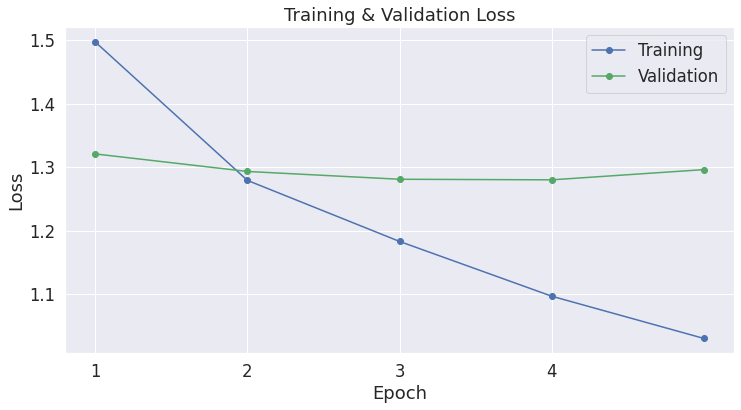

In [ ]:
import matplotlib.pyplot as plt

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# 파라미터 표시
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (42007, 768)
transformer.wpe.weight                                   (2048, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
# 모델 저장

output_dir = '/content/drive/MyDrive/model_save'

# 디렉토리 만들기
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# 모델, 토크나이저 등 저장
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_gpt3.save_pretrained(output_dir)

Saving model to /content/drive/MyDrive/model_save


('/content/drive/MyDrive/model_save/tokenizer_config.json',
 '/content/drive/MyDrive/model_save/special_tokens_map.json',
 '/content/drive/MyDrive/model_save/vocab.txt',
 '/content/drive/MyDrive/model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K /content/drive/MyDrive/model_save

total 513971K
-rw------- 1 root root      1K Mar  4 08:35 added_tokens.json
-rw------- 1 root root      1K Mar  4 08:35 config.json
-rw------- 1 root root 513632K Mar  4 08:35 pytorch_model.bin
-rw------- 1 root root      1K Mar  4 08:35 special_tokens_map.json
-rw------- 1 root root      1K Mar  4 08:35 tokenizer_config.json
-rw------- 1 root root    337K Mar  4 08:35 vocab.txt


In [ ]:
!ls -l --block-size=M /content/drive/MyDrive/model_save/pytorch_model.bin

-rw------- 1 root root 502M Mar  4 08:35 /content/drive/MyDrive/model_save/pytorch_model.bin


In [ ]:
# !cp -r /content/drive/MyDrive/model_save/ $data_dir

cp: missing destination file operand after './model_save/'
Try 'cp --help' for more information.


In [ ]:
# 구글 드라이브에서 모델, 토크나이저 불러오기

model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/model_save')
# gpt3-kor-small_based_on_gpt2
from transformers import BertTokenizerFast, GPT2LMHeadModel
tokenizer = BertTokenizerFast.from_pretrained('/content/drive/MyDrive/model_save')
input_ids = tokenizer.encode("text to tokenize")[1:]  # remove cls token

# Generate Text

* generate 함수 


In [ ]:
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = model.to(device)

In [ ]:
model.eval()

prompt = "<|startoftext|> <2세대> 배고프다"
generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3,
                                repetition_penalty=1.2
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[    2, 42000, 42004, 40639,  8013,     3]], device='cuda:0')
0: 배고프다 니 목소리만 듣고 있어 <br> 왜 자꾸 너한테 전화를 안 해 <br> 뭐해 먹고 싶어 뭘 해야 돼 <br> 오늘 하루만 넌 쉬고 싶은데 <br> 너 땜에 짜증이 늘어가고 있어 <br> 나 지금 화가나 미칠 것만 같아 <br> 내가 너를 좀 들게 하면 안돼 <br> 널 보면 안 되니까 <br> i want you right now its over <br> its over <br> dont leave me alone <br> 내 옆엔 니가 없는데 oh my girl <br> 이 손 놔줄래 제발 가지마 나 정말 화났어 <br> 왜 자꾸 너한테 전화 안 해 <br> 뭐해 먹고 싶어 뭘 해야 돼 <br> 오늘 하루만 넌 쉬고 싶은데 <br> 너 땜에 짜증이 늘어가고 있어 <br> 한 눈 팔지마 못 봐 줄 거니 <br> 내가 필요할 땐 언제든지 찾아와줘 <br> i want you right now its over <br> its over <br> dont leave me alone <br> 네 곁에는 나만 있는데 oh my love <br> 이 손 놔줄래 제발 가지마 나 정말 화났어요 <br> 그만할래 제발 나를 떠난다고 <br> 내게 말을 하지 말걸 <br> 사랑한다는 그 말이 더 아플 걸 알아 <br> 이젠 말해 줘 네가 잘 알잖아 <br> 내가 너만을 아끼고 있단 걸 uh <br> 괜찮아 죽겠어 내일까지만 참아볼게 <br> 제발 부탁해 baby boy ma cash <br> 날 갖고 놀아 달라고 <br> 다신 돌아오지 마 oh babe <br> 날 버리지 말아줘 never mind <br> 내 옆에만은 아무도


1: 배고프다 왜 그렇게 나 안 먹냐고 <br> 친구들이 내게 묻곤 해 <br> 내가 잘 하는 거 있냐구 <br> 내 맘에 꼭 든다고 <br> 그런 말들로 매일 나를 놀려대 <br> 그래서 난 <br> 밥 대신 라면

#1세대 테스트

In [ ]:
prompt = "<|startoftext|> <1세대> 배고프다 "
generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3,
                                repetition_penalty=1.2
                                )

for i, sample_output in enumerate(sample_outputs):
  result = "{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))
  result = re.sub(r"<br>", "\n", result)
  print(result)

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42003, 40639,  8013,     3]], device='cuda:0')
0: 배고프다 배가 고프다 
 오늘 하루만 나 좀 내버려둬라 
 어제도 오늘도 
 똑같은 말 일텐데 
 이렇게 또 눈물짓지마 
 우리 헤어져버렸잖아 
 아무리 달래봐도 
 다시 너의 생각만 하면 
 난 어떡하라고 
 다신 너를 볼 수 없단걸 알지만 
 널 울리지 않는 방법밖에 없어 
 i cried in you uh uh 
 아무 말도 못하는 너 
 이젠 내게 기대줘 제발 떠나가줘 
 oh baby cant stop me now 
 내 두 귀를 막아버린 그 사람 
 한땐 모든 걸 주던 
 그런 니가 이제 그리워졌어 
 얼마나 더 아파야 하는데 
 날 떠날 생각 하지마 
 이렇게 보낼순 없어 
 다시 돌아와 줄 순 없니 
 사랑해 정말 미안해 
 너무 들어 
 다시는 이런 사랑 하지 마 
 내 마음 들킨거 맞죠 
 어떻게 된 일이라도 난 말해봐요 
 정말 미안하단 말조차 
 꺼내지도 마요 
 아직도 가슴이 아프지만 
 그래도 넌 항상 그래주길 바랬는데 
 이렇게 보냈으니 
 이렇게 보내야 한다는게 
 다신 아프기만 할테니까


1: 배고프다 참아본다 
 배고프지 않으면 밥 굶는다 
 내가 뭐를 먹었는지 기억도 안나 
 라면 하나 먹자 
 밥은 잘 챙겨 먹었냐 
 물도 많이 마셨냐 
 야야 라면 먹고 살기 바쁘구나 
 배고프지 않으면 나가서 밥을 먹어라 
 배가 고프고 나면은 또 뭔가 허전하다 
 너무 배고파도 뭘 먹니 
 야이야 이 노래를 부른다면 너와 함께 웃고 있을텐데 
 야이야 
 야이야 
 야이야 이 노래를 부른다면 너에게 하고 싶은 말 
 야이야 이 노랠 듣는다면은 난 정말 하늘을 날 것 같은데 
 야이야 
 야이야 이 노래를 부른다면 너에게 하고픈 말 
 야이야 이 노랠 듣는다면은 난 정말 하늘을 날아갈 것 같은데


2: 배고프다 oh god 
 굶주린 사자처럼 
 어질러진 내 방구석을 
 엉망으로 만들어버린 널 
 집어쳐 버리고 싶어 


#2세대 테스트

In [ ]:
prompt = "<|startoftext|> <2세대> 배고프다 "
generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3,
                                repetition_penalty=1.2
                                )

for i, sample_output in enumerate(sample_outputs):
  result = "{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))
  result = re.sub(r"<br>", "\n", result)
  print(result)

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42004, 40639,  8013,     3]], device='cuda:0')
0: 배고프다 밥보다 니 생각이 난다 
 내 방에 tv를 켜면 
 네 번호가 떠있다 
 난 너에게 전화를 건다 
 오늘도 나는 잠이 든다 
 널 위한 노래 한 곡 듣고서 
 네 곁으로 가는 길 
 혹시 이 길이 맞지 그렇다면은 
 지금 여기서 내가 나가는 거야 
 너는 알겠지 나의 모든 걸 다 알고 있는 걸 
 그 어떤 말도 필요 없단 걸 
 내 맘을 네게 보여주겠어 babe 
 i dont know love you babe 
 시간이 멈췄으면 해 
 제발 날 떠나지 말아줘 제발 
 이렇게 애타는 내게로 와줄래 
 너의 귓가에 속삭이는 
 소리 들려와 tonight 
 이 꿈에서 깨지마 
 내 손을 꼭 잡아줘 my sweety girl 
 넌 아무 것도 못 하잖아 
 너만 보이는 나는 뭐 
 its no more i am forever 
 너만 들리고 싶은 이 말 사랑해 
 
 가끔은 그냥 네가 보고 싶어 
 너만의 멜로디를 듣고 싶다 
 네 목소린 어떨까 넌 어떨지 내 마음을 
 아주 가끔 혼자 상상해 
 im taking for your dreams baby 
 나를 안아 줘 
 너의 작은 어깨에 기대줘 makes me crazy 
 너의 품 안에 날 데려가줘 ma lady 
 난 절대로 너를 놓지 않을 거야 
 i wanna be with u girl 
 baby yo yo


1: 배고프다 나 이제 밥 좀 먹자 
 엄마 손잡고 나갔더니 
 엄마 뭐 해왔냐 묻더라 
 난 원래 밥을 잘 안 먹는 데 
 왜 이리 내 생각은 안 하는지 
 엄마의 손을 꼭 잡고서 
 같이 걸어도 보고 
 길을 걸어도 보고 
 근데 너 왜 그렇게 날 찾는지 
 엄마가 사준 장갑을 끼고서 
 길을 걷다가 내가 쳐다볼 때 
 아무 말도 않고 서 있는 
 니가 너무 귀여워보여 oh baby 
 집에 가기 싫다고 짜증을 내고 있지만 
 밥 먹고 싶은 게 아니야 
 엄마 옆에 

#3세대 테스트

In [ ]:
prompt = "<|startoftext|> <3세대> 배고프다 "
generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3,
                                repetition_penalty=1
                                )

for i, sample_output in enumerate(sample_outputs):
  result = "{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))
  result = re.sub(r"<br>", "\n", result)
  print(result)

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42005, 40639,  8013,     3]], device='cuda:0')
0: 배고프다 빨리 집을 나서 
 니가 너무 보고 싶다 
 빨리 집에 나가 
 왜 그러니 내가 귀찮대 
 그럼 짜증나니까 
 우리 집에 가자 
 넌 지금 어디있니 
 baby plz come here we go 
 i wanna give you a little bit flow right now 
 뭘 그리 망설이니 girl 
 i want it love me too hot 
 니 핸드폰은 충전이 안돼 only one 
 난 오늘 널 보러 가야돼 
 나 오늘 너와 약속할게 
 전화기는 끄고 자야지 
 폰이 꺼져있어 나 어떡하니 baby girl 
 빨리 집에 서둘러서 
 집으로 가는 길 내내 니 생각만 났어 
 집 앞이야 어서 나와 함께 가줘 
 밥 먹고 영화도 보자 
 너의 집 앞에 데려다 줄래 oh lady 
 baby plz come here we go 
 i wanna give you a little bit flow right now 
 어딜 이리 왔니 girl 
 i wanna give you a little bit flow right now 
 무슨 일 있었냐고 묻길래 
 그냥 같이 놀자고 한 것뿐이라고 했더니만 
 u what u say im falling in love with you 
 너도 그 생각 해봤잖아 
 지금 뭐하냐고 자꾸 물어보면 곤란하니까 
 집에 가기 전에 잘 생각해둬 다 후회할걸 
 i cant leave this world 



1: 배고프다 나 지금 라면 먹고 갈까 
 아님 이 집에서 밥 먹을까 
 네게 물어볼까 아니면 네가 집에 없더라도 
 말해 볼까 하고 있는데 
 난 너에게 너무 집중을 하는 걸 
 이렇게 모든 게 다 낯설어 
 한 눈팔지 않고 내 맘은 다 열어 둔 채로 
 이런 시간이 계속 반복되면 
 널 보면 그냥 아무 말도 못하고 멍해져 
 조금 더 가까이 다가갈까 
 너의 손짓 하나까지 널 위해 준비했

# 생성기

In [ ]:
def lyric_generator(gen, lyric):
  prompt = f"<|startoftext|> <{gen}세대> {lyric}"
  generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
  generated = generated.to(device)

  print(generated)

  sample_outputs = model.generate(
                                  generated, 
                                  #bos_token_id=random.randint(1,30000),
                                  do_sample=True,   
                                  top_k=50, 
                                  max_length = 300,
                                  top_p=0.95, 
                                  num_return_sequences=3,
                                  repetition_penalty=1.1
                                  )

  for i, sample_output in enumerate(sample_outputs):
    result = "{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))
    result = re.sub(r"<br>", "\n", result)
    print(result)
  return

In [ ]:
lyric_generator(2, '배고프다')

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42004, 40639,  8013,     3]], device='cuda:0')
0: 배고프다 네게 좀 붙어줄래 
 넌 항상 이래 
 난 매일 세끼니 챙겨 먹어 난 배고파 
 넌 가끔 한 끼니 건너뛸 땐 
 세끼니 잘 챙겨 먹어 세끼니 
 근데 내가 너무 맛없어 yeah 
 i dont know why 
 너 지금 무슨 생각해 oh no 
 네 옆에 있잖아 
 그 표정은 왜 그래 
 내 맘을 미치게 해 yeah 
 나에겐 맛있는 음식이 많아 다 맛있는 걸 
 내 안에 있는 걸 이렇게 널 느껴 
 yeah yeah 
 내게 다가와 줘 
 i want you back to me 
 i want you back to me 
 나 지금 니가 좋은 거야 
 yes its all good fresh night 
 내가 원한 건 네가 아닌 것 같아 
 but its okay to you 
 니 맘 안에 있는 그 모든 것 
 우리 같이 나눌 수 있어 너무 행복해 
 나는 너를 보고 있어 
 너를 사랑하고 있어 지금 이 순간 
 함께인 거야 너무 고마워 정말 좋아 
 너만을 보고 있어 
 너를 사랑하고 있어 지금 이 순간 
 함께인 거야 너무 고마워 정말 좋아 
 너만을 안고 있어 
 yes its all good fresh night 
 you think im like a target 
 for your side is yourside 
 my eyes in the mood and crazy 
 forever and ever had to be free 
 making love place and cuz 
 we


1: 배고프다 우리 같이 놀자 
 놀자 저길 봐라 
 배고프지 배고프다 
 우리 같이 놀자 
 배고프지 배고프다 
 oh 놀자 time i miss u 
 배고파 배고프다 
 oh wait up to you 
 배고프지 배고프다 
 배고프지 배고프다 
 우리 같이 놀자 
 놀자 저길 봐라 
 배고프지 배고프다 
 oh 놀자 time i